In [1]:
import nest
import matplotlib.pyplot as plt
import numpy as np
import math

# The dish class
on which we can generate patterned cell stimulation

In [164]:

class Dish():
    def __init__(self, quick=False):
        self.simLength = 1000 #ms
        self.recorders_list = []
        self.massRecorders_list = []
        self.stimuli_list = []
        self.quick = quick
        nest.ResetKernel()

        # Simulation kernel
        nest.SetKernelStatus({
            "local_num_threads": 1,
            "resolution": 0.1
        })

    # run the simulation and display the results
    # verbosity defines which graphs are displayed: 1-none, 2-spikes & stimulation, 3-full multimeter recording
    def record(self, verbose = 4):
        # Run simulation
        nest.Simulate(self.simLength)

        # Define function getting activity from the recorder
        def getActivity(node):
            if node.get("model") == "spike_recorder":
                nodeIds = nest.GetConnections(None, node).sources()
            else:
                nodeIds = nest.GetConnections(node).targets()
            return {
                "events": node.get("events"),
                "nodeIds": list(nodeIds),
                "model": node.get("model")
            }

        # Collect activities
        recordersActivity = [getActivity(recorder) for recorder in self.recorders_list]
        results = []
        counter = 0
        for data in recordersActivity:
            events = None
            if data["model"] == "spike_recorder" and verbose == 1:
                freq = "of frequency "+ str(np.mean(np.diff(np.array(data["events"]["times"])))) if len(data["events"]["times"])>1 else ""
                print("for", counter, "found", len(data["events"]["times"]), "spikes", freq)
                plt.plot(data["events"]["times"], [counter for _ in data["events"]["times"]] , 'rx')
                events = data["events"]["senders"]
                counter = counter + 1
            if data["model"] == "spike_recorder" and verbose > 1:
                plt.figure(figsize=(20,5))
                plt.title(data["nodeIds"])
                plt.plot(data["events"]["times"], data["events"]["senders"], 'rx')
                events = data["events"]["senders"]
                if verbose > 2:
                    for i,stim in enumerate(self.stimuli_list):
                        plt.plot([j for j in range(len(stim)) if stim[int(j)]==1],[i for j in stim if j==1], 'd')
                
            elif data["model"] == "multimeter" and verbose > 3:
                plt.figure(figsize=(20,5))
                plt.title(data["nodeIds"])
                plt.plot(data["events"]["times"], data["events"]["V_m"])
                events = data["events"]["V_m"]
            
            results.append({
                "type": data["model"],
                "times": data["events"]["times"], 
                "events": events
            })
        
        # return debugging information
        events = []
        if not self.quick:
            for data in [getActivity(recorder) for recorder in self.massRecorders_list]:
                events.append(data["events"]["times"])
        return events
        
    
    # add a spike recorder and a multimeter monitors to the node
    def monitorNode(self, node):
        if not self.quick:
            multimeter = nest.Create("multimeter", params={"record_from": ["V_m"]})
            self.recorders_list.append(multimeter)
            self.connect(multimeter, node)

        spikeRecorder = nest.Create("spike_recorder")        
        self.recorders_list.append(spikeRecorder)
        self.connect(node, spikeRecorder,1)
        
        return node
        
    
    # make simple neuron node
    def node(self):
        node = nest.Create("iaf_psc_alpha", 1, params={"C_m": 250.0,"tau_m": 10.0})
        
        # spike recording of the whole dish
        if not self.quick:
            spikeRecorder = nest.Create("spike_recorder")
            self.connect(node, spikeRecorder,1)
            self.massRecorders_list.append(spikeRecorder)
            
        return node


    # generators
    def stimulateNode(self, node, spikes = None):
        stimulator = None
        if spikes is None:
            self.connect(
                nest.Create("dc_generator", 1, params={"amplitude": 400.0}), 
                node)
            self.stimuli_list.append([1 for _ in range(self.simLength)])
        else:
            if callable(spikes):
                spikes = [i for i in range(1,self.simLength+1) if spikes(i)>0.95]
            self.connect(
                nest.Create("spike_generator", 1, params={
                    "spike_times": [x*1.0 for x in spikes] }),
                node,
                1)
            self.stimuli_list.append([1 if j*1.0 in spikes else 0 for j in range(self.simLength)])
        return node
    
    
    # mutable node
    def mutableNode(self, node, freq=3, start=1, magnitude=1000):
        self.connect(
            nest.Create("spike_generator", 1, params={
                "spike_times": [x*1.0 for x in range(int(start+freq/2),self.simLength,freq)]}),
            node,
            -1*magnitude) # inhibitory muting connection
        
    
    # conections
    # weight of 1 means that the spike will propegate to the next node
    # delay is used to make the RNN nodes
    def connect(self, src, dst, weight = None, delay = None):
        # set connection weight - 1 will induce a spike by its own
        synSpec = {} if weight == None else {"weight": 1200 * weight}
        
        # set connection delay 
        synSpec.update({} if delay == None else {"delay": 23.0 * delay})
        
        nest.Connect(src, dst, syn_spec=synSpec)
        
        return {"src":src, "dst":dst}
        


## tests:

dish = Dish()

node = dish.node()
node2 = dish.node()

dish.stimulateNode(node, lambda x : math.sin(0.1*x))
#dish.stimulateNode(node)
dish.connect(node, node2, 1)
dish.monitorNode(node2)

dish.record(3)

# The Network class
this class will give an easy API to generate networks that resemble RNNs

In [165]:
class DishNetwork():
    def __init__(self, layers, weights):
        self.dish = Dish()
        self.inputLayer = []
        self.layers = layers
        self.weights = weights
        self._mkANN(layers, weights)
    
    def _connectLayers(self, this, that, weights, delay = None):
        print("connecting layer", len(this), len(that))
        for n1 in range(len(this)):
            if n1%100 == 0:
                print("connected",n1,"nodes in the layer")
            for n2 in range(len(that)):
                if(weights[n1][n2] != 0):
                    #print(n1,"->",n2,float(weights[n1][n2]))
                    self.dish.connect(this[n1], that[n2], float(weights[n1][n2]), delay)
        
    def _connectRecurrentLayer(self, layer, weights):
        #print("adding recurrent layer of",layer)
        recLayer = [self.dish.node() for _ in range(len(layer))]
        self._connectLayers(layer, recLayer, [[1 if i == j else 0 for i in range(len(layer))] for j in range(len(layer))], 0.5)
        self._connectLayers(recLayer, layer, weights, 0.5)
    
    def _mkANN(self, layers, weights):
        assert(len(layers)==len(weights)+1)
        #print("simulating ANN of layers",layers)
        self.inputLayer = [self.dish.node() for i in range(layers[0])]
        lastLayer = self.inputLayer
        
        for layer, weight, idx in zip(layers[1:], weights, range(len(weights))):
            nextLayer = [self.dish.node() for i in range(layer)]
            # recurrent weights
            if type(weight) is tuple:
                self._connectRecurrentLayer(lastLayer, weight[1])
                weight = weight[0]
            self._connectLayers(lastLayer, nextLayer, weight)
            #to monitor all
            #[self.dish.monitorNode(node) for node in lastLayer]   
            
            #to mute repetition
            [self.dish.mutableNode(node,freq=3,start=6+3*idx, magnitude=10000) for node in lastLayer]
            
            # noise supression
            if idx<len(weights)-1:
                k = int(layer/2)
                neg = nextLayer[k:]
                pos = nextLayer[:k]
                self._connectLayers(neg, pos, (-1*torch.eye(k)).tolist())
                self._connectLayers(pos, neg, (-1*torch.eye(k)).tolist())
            lastLayer = nextLayer
        [self.dish.monitorNode(node) for node in lastLayer] 
    
    # stimulate the network
    # accepts a function as stimulation f(i,t)=1 iff the node i spikes at time t, f(i,t)=0 otherwise
    # accepts a 2D list where list[i][t]=1 iff the node i spikes at time t, list[i][t]=0 otherwise
    def stimulate(self, stim = None, simLen = 1000, verbosity = 3):
        self.dish.stimuli_list = []
        self.dish.simLength = simLen
        for i, neuron in enumerate(self.inputLayer):
            if i%20 == 0:
                pass #print("connected stimulation to",i,"nodes")
            if not stim:
                self.dish.stimulateNode(neuron)
            elif callable(stim):
                self.dish.stimulateNode(neuron, lambda t: stim(i,t))
            elif type(stim) is list:
                self.dish.stimulateNode(neuron, stim[i])
        print("starting to record")
        events = self.dish.record(verbosity)
        layeredEvents = []
        if events != []:
            for layer in self.layers:
                layeredEvents.append(events[:layer])
                events = events[layer:]
        return layeredEvents


# Examples

## simple line network that propegate the signal

net = DishNetwork([1,1,1,1],[[[1]],[[1]],[[1]]])
net.stimulate()


connecting layer 1 2
connected 0 nodes in the layer
starting to record


[[array([ 28.9,  58.7,  88.5, 118.3, 148.1, 177.9, 207.7, 237.5, 267.3,
         297.1, 326.9, 356.7, 386.5, 416.3, 446.1, 475.9, 505.7, 535.5,
         565.3, 595.1, 624.9, 654.7, 684.5, 714.3, 744.1, 773.9, 803.7,
         833.5, 863.3, 893.1, 922.9, 952.7, 982.5])],
 [array([ 35.2,  64.8,  94.6, 124.4, 154.2, 184. , 213.8, 243.6, 273.4,
         303.2, 333. , 362.8, 392.6, 422.4, 452.2, 482. , 511.8, 541.6,
         571.4, 601.2, 631. , 660.8, 690.6, 720.4, 750.2, 780. , 809.8,
         839.6, 869.4, 899.2, 929. , 958.8, 988.6]),
  array([ 35.2,  64.8,  94.6, 124.4, 154.2, 184. , 213.8, 243.6, 273.4,
         303.2, 333. , 362.8, 392.6, 422.4, 452.2, 482. , 511.8, 541.6,
         571.4, 601.2, 631. , 660.8, 690.6, 720.4, 750.2, 780. , 809.8,
         839.6, 869.4, 899.2, 929. , 958.8, 988.6])]]

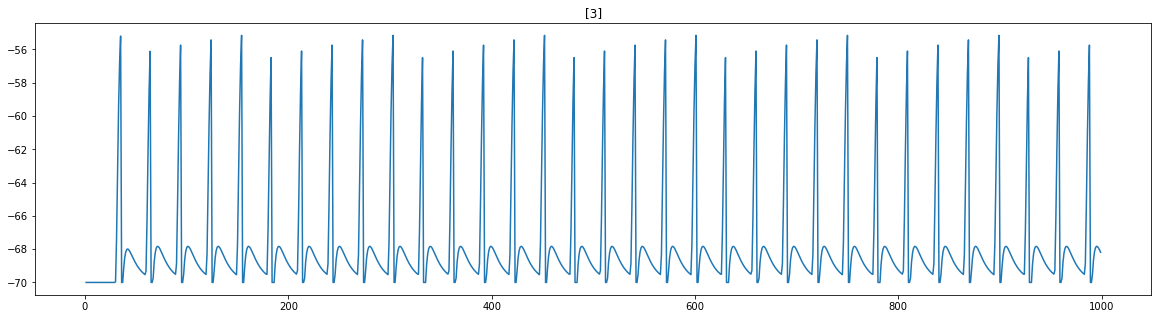

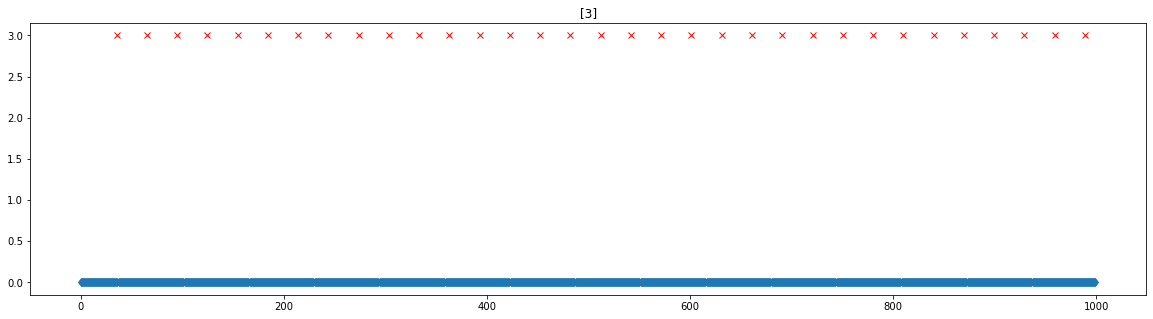

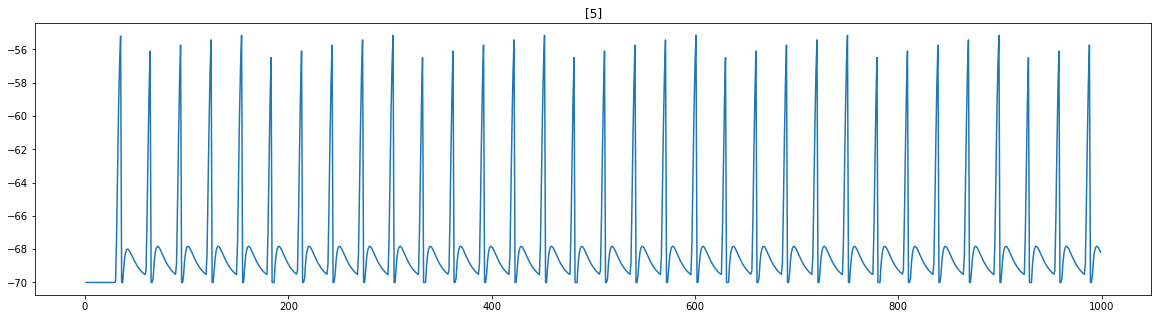

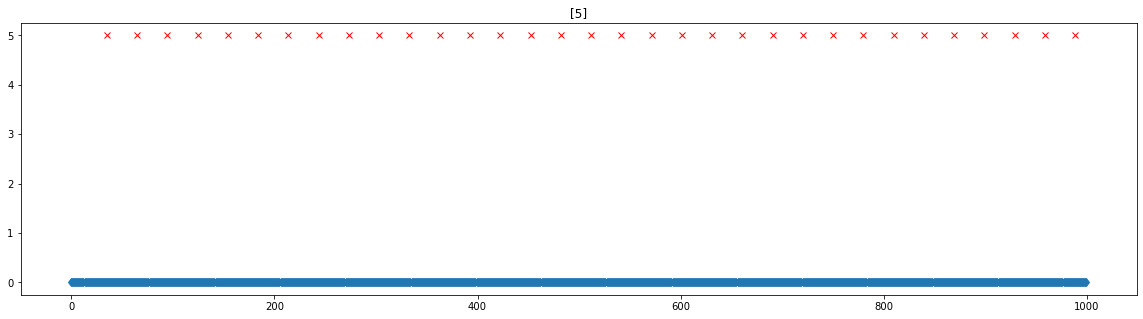

In [128]:
## 1 node connects to 2 nodes

net = DishNetwork([1,2],[[[1,1]]])
net.stimulate(verbosity=4)

## 2 nodes connect to 1 node

net = DishNetwork([2,1],[[[1],[1]]])
net.stimulate()

## small network with an RNN layer

net = DishNetwork([1,1],[([[1]],[[1]])])
net.stimulate(lambda i,t: 1 if t == 1 else 0)

## inhibitory connections

net = DishNetwork([2,1],[[[1],[-1]]])
net.stimulate(lambda i,t: 1 if t % 30 == 0 and i == 0 else (1 if t % 60 == 0 and i == 1 else 0))

## inhibitory connections disabling an RNN feedback loop

net = DishNetwork([2,1,1],[[[1],[-1]],([[1]],[[1]])])
net.stimulate([[10, 400, 800],[200, 600]])

connecting layer 6 1
connected 0 nodes in the layer
starting to record


[[array([106.3, 206.3, 306.3, 406.3, 506.3, 606.3, 706.3]),
  array([406.3, 506.3, 606.3, 706.3]),
  array([606.3, 706.3]),
  array([206.3, 306.3, 406.3, 506.3, 606.3, 706.3]),
  array([306.3, 506.3, 606.3, 706.3]),
  array([706.3])],
 [array([112.6, 412.6, 612.6])]]

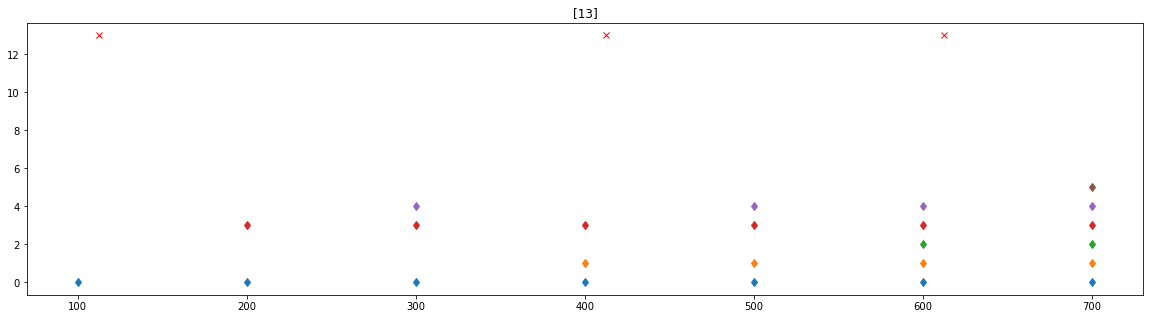

In [5]:
## exitory vs inhibitory

net = DishNetwork([6,1],[[[1],[1],[1],[-1],[-1],[-1]]])
net.stimulate([[100,200,300,400,500,600,700],[400,500,600,700],[600,700],[200,300,400,500,600,700],[300,500,600,700],[700]])

# translating the model

In [6]:
import argparse
import torch
import torch.nn as nn

def SimfromModel(trainedModel):
    weights = []
    layers = []
    state = trainedModel.state_dict()
    nextLayer = 0
    for key, value in state.items():
        #print("parsing layer:",key, value.size())
        if key.split(".")[1] == "weight" and key.split(".")[0].startswith("fc"):
            layers.append(value[0].size()[0]*2)
            nextLayer = value.size()[0]*2
            W1 = torch.cat((value, -1*value) , 0)
            W2 = torch.cat((-1*value, value) , 0)
            weights.append(torch.transpose(torch.cat((W1,W2),1),0,1))

    layers.append(nextLayer)
    
    layers[0] = int(layers[0]/2)
    layers[-1] = int(layers[-1]/2)
    weights[0] = weights[0].narrow(0,0,int(weights[0].size()[0]/2))
    weights[-1] = weights[-1].narrow(1,0,int(weights[-1].size()[1]/2))
    print("first mat dims",weights[0].size())
    print("last mat dims",weights[-1].size())
    return DishNetwork(layers, weights)

## simulating the model

first mat dims torch.Size([1, 2])
last mat dims torch.Size([2, 1])
connecting layer 1 2
connected 0 nodes in the layer
connecting layer 1 1
connected 0 nodes in the layer
connecting layer 1 1
connected 0 nodes in the layer
connecting layer 2 2
connected 0 nodes in the layer
connecting layer 1 1
connected 0 nodes in the layer
connecting layer 1 1
connected 0 nodes in the layer
connecting layer 2 1
connected 0 nodes in the layer
starting to record


[[array([7.3])],
 [array([13.6]), array([], dtype=float64)],
 [array([19.9]), array([], dtype=float64)],
 [array([26.2])]]

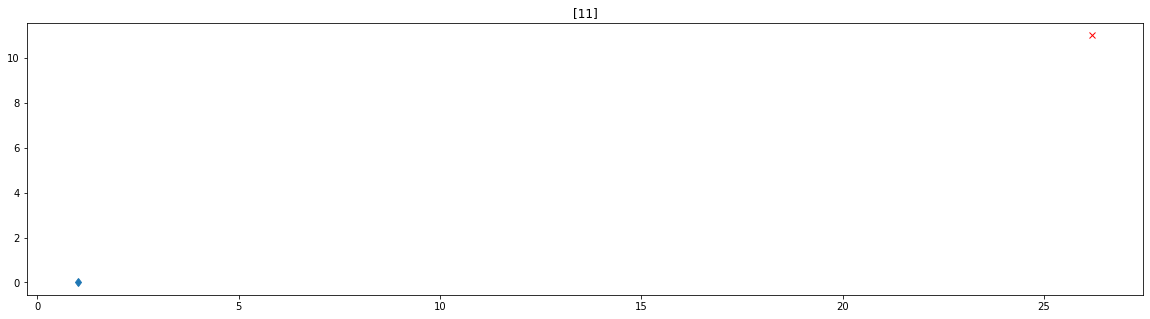

In [7]:
# simple propegation of positive signal
def Binarize(tensor, include_zero = False):
    if include_zero:
        N_std = 1
        up = (tensor>0 + N_std*tensor.std()).float()
        down = (tensor<0 - N_std*tensor.std()).float().mul(-1)
        return (up + down)
    else:
        return tensor.sign()

    
class BinarizeLinear(nn.Linear):

    def __init__(self, *kargs, **kwargs):
        super(BinarizeLinear, self).__init__(*kargs, **kwargs)

    def forward(self, input):

        if input.size(1) != 784:
            input.data=Binarize(input.data)
        if not hasattr(self.weight,'org'):
            self.weight.org=self.weight.data.clone()
        self.weight.data=Binarize(self.weight.org)
        out = nn.functional.linear(input, self.weight)
        if not self.bias is None:
            self.bias.org=self.bias.data.clone()
            out += self.bias.view(1, -1).expand_as(out)

        return out
    

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = BinarizeLinear(1, 1, bias=False)
        self.fc2 = BinarizeLinear(1, 1, bias=False)
        self.fc3 = BinarizeLinear(1, 1, bias=False)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x
    
model = Net()
model.load_state_dict(torch.load("mnist_trained_dummy.pt",map_location=torch.device('cpu')))
model.eval()
net = SimfromModel(model)
net.stimulate([[1]], simLen = 100, verbosity=3)

model result: tensor([[1.]])
first mat dims torch.Size([1, 2])
last mat dims torch.Size([2, 1])
starting to record


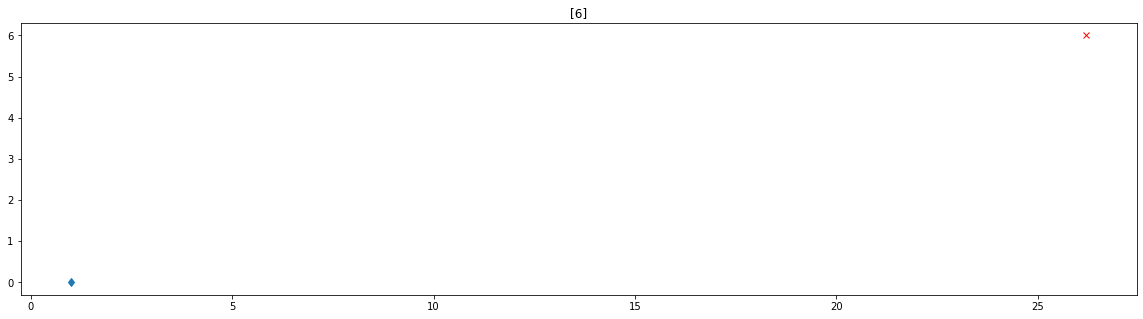

In [98]:
# simple propegation of positive signal
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = BinarizeLinear(1, 1, bias=False)
        self.fc2 = BinarizeLinear(1, 1, bias=False)
        self.fc3 = BinarizeLinear(1, 1, bias=False)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

stim = [[1.0]]
model = Net()
with torch.no_grad():
    model.fc1.weight[0, 0] = 1.0
    model.fc2.weight[0, 0] = 1.0
    model.fc3.weight[0, 0] = 1.0
    print("model result:", model(torch.as_tensor(stim).transpose(0,1)))
    
net = SimfromModel(model)
net.stimulate(stim, simLen = 100, verbosity=3)

model result: tensor([[1.]])
first mat dims torch.Size([1, 2])
last mat dims torch.Size([2, 1])
connecting layer 1 2
connected 0 nodes in the layer
connecting layer 2 2
connected 0 nodes in the layer
connecting layer 2 1
connected 0 nodes in the layer
starting to record


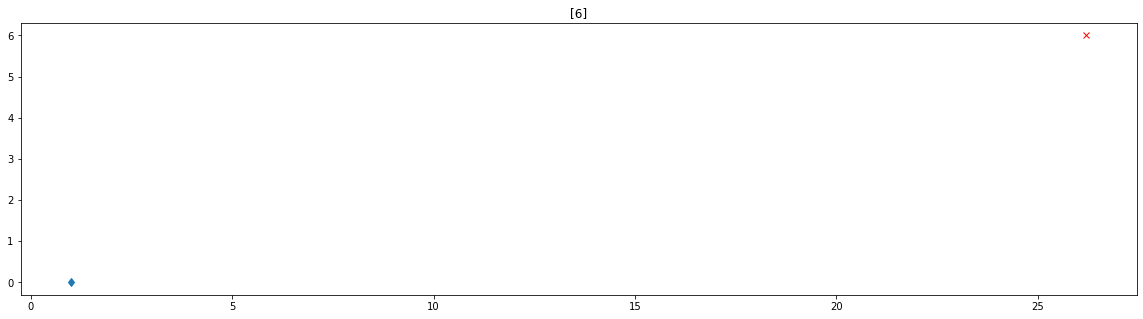

In [26]:
# simple propegation of negative signal
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = BinarizeLinear(1, 1, bias=False)
        self.fc2 = BinarizeLinear(1, 1, bias=False)
        self.fc3 = BinarizeLinear(1, 1, bias=False)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

stim = [[1.0]]
model = Net()
with torch.no_grad():
    model.fc1.weight[0, 0] = -1.0
    model.fc2.weight[0, 0] = 1.0
    model.fc3.weight[0, 0] = -1.0
    print("model result:", model(torch.as_tensor(stim).transpose(0,1)))
    
net = SimfromModel(model)
net.stimulate(stim, simLen = 100, verbosity=3)

model result: tensor([[ 5., -5.]])
first mat dims torch.Size([5, 4])
last mat dims torch.Size([4, 1])
connecting layer 5 4
connected 0 nodes in the layer
connecting layer 4 4
connected 0 nodes in the layer
connecting layer 4 1
connected 0 nodes in the layer
starting to record


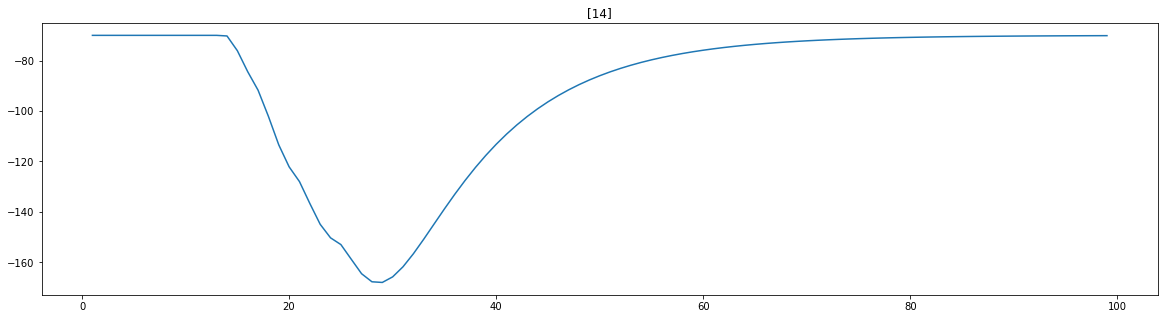

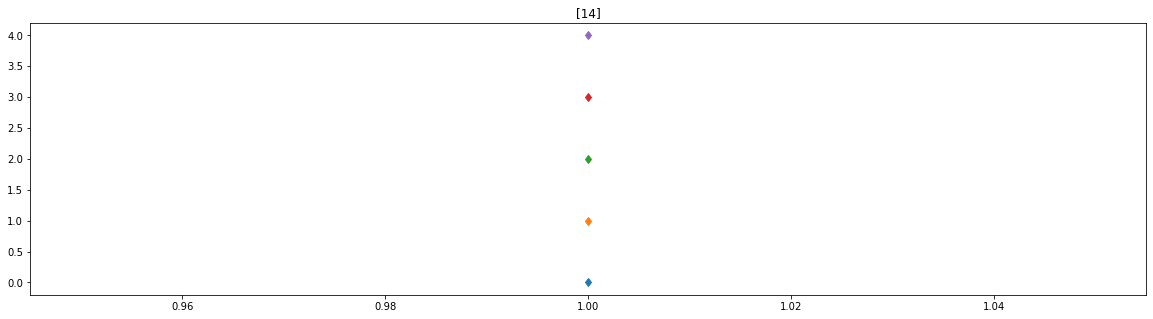

In [37]:
# input overload signal
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = BinarizeLinear(5, 2, bias=False)
        self.fc2 = BinarizeLinear(2, 2, bias=False)
        self.fc3 = BinarizeLinear(2, 1, bias=False)

    def forward(self, x):
        x = self.fc1(x)
        return x

stim = [[1.0],[1.0],[1.0],[1.0],[1.0]]
model = Net()
with torch.no_grad():
    model.fc1.weight[0, 0] = 1.0
    model.fc1.weight[0, 1] = 1.0
    model.fc1.weight[0, 2] = 1.0
    model.fc1.weight[0, 3] = 1.0
    model.fc1.weight[0, 4] = 1.0
    
    model.fc1.weight[1, 0] = -1.0
    model.fc1.weight[1, 1] = -1.0
    model.fc1.weight[1, 2] = -1.0
    model.fc1.weight[1, 3] = -1.0
    model.fc1.weight[1, 4] = -1.0
    
    model.fc2.weight[0, 0] = -1.0
    model.fc2.weight[0, 1] = 1.0
    model.fc2.weight[1, 0] = 1.0
    model.fc2.weight[1, 1] = -1.0
    
    model.fc3.weight[0, 0] = 1.0
    model.fc3.weight[0, 1] = -1.0
    
    print("model result:", model(torch.as_tensor(stim).transpose(0,1)))
    
net = SimfromModel(model)
net.stimulate(stim, simLen = 100, verbosity=4)

Parameter containing:
tensor([[0.0386]], requires_grad=True)
model result: tensor([[5.]])
first mat dims torch.Size([5, 2])
last mat dims torch.Size([2, 1])
starting to record


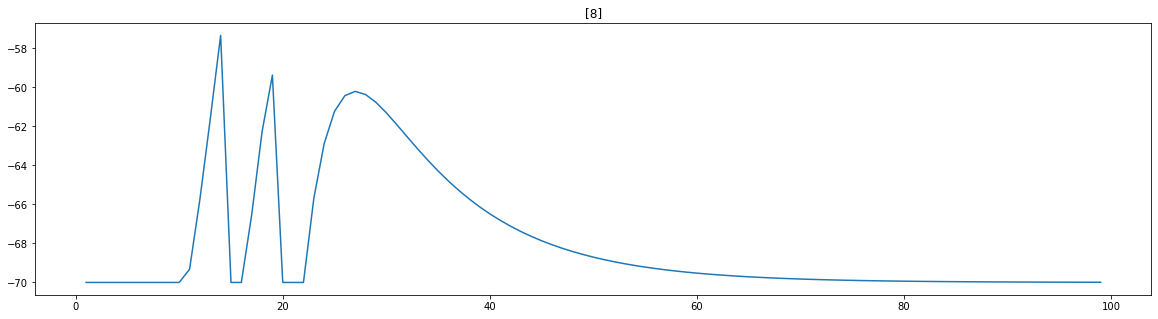

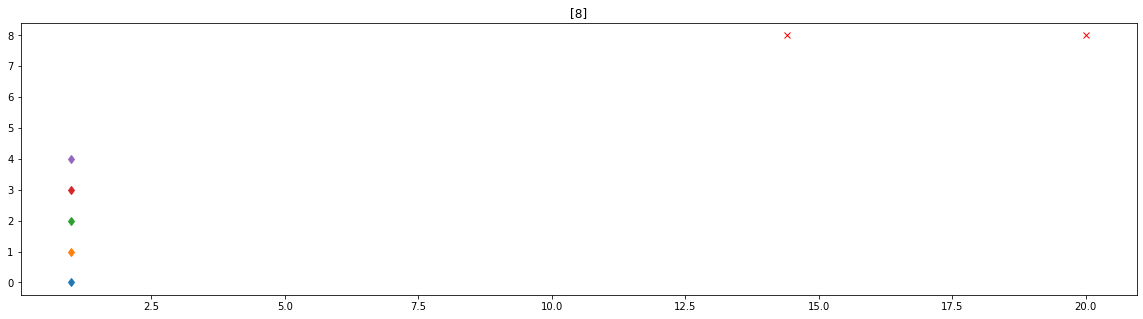

In [115]:
# input overload signal
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = BinarizeLinear(5, 1, bias=False)
        self.fc2 = BinarizeLinear(1, 1, bias=False)

    def forward(self, x):
        x = self.fc1(x)
        return x

stim = [[1.0],[1.0],[1.0],[1.0],[1.0]]
model = Net()
with torch.no_grad():
    print(model.fc2.weight)
    model.fc1.weight[0, 0] = 1.0
    model.fc1.weight[0, 1] = 1.0
    model.fc1.weight[0, 2] = 1.0
    model.fc1.weight[0, 3] = 1.0
    model.fc1.weight[0, 4] = 1.0
    
    model.fc2.weight[0, 0] = 1.0 
    print("model result:", model(torch.as_tensor(stim).transpose(0,1)))
    
net = SimfromModel(model)
net.stimulate(stim, simLen = 100, verbosity=4)

## MNIST tests

In [8]:
import pickle
sampleData = None
with open("sampleData",'rb') as file:
    sampleData = pickle.load(file)
   
cleanSamples = {}
for data, label in sampleData[20:]:
    cleanSamples.update({label:(data>=0).int()})

#for label in cleanSamples.keys():
#cleanSamples[0][0]
def samples2stim(sample):
    arr = []
    for row in sample:
        for cell in row:
            if cell == 1:
                arr.append([1])
            else:
                arr.append([])
    return arr


#for label in cleanSamples.keys():      
#print(samples2stim(cleanSamples[1][0]))
#net.stimulate(samples2stim(cleanSamples[8][0]), simLen = 100, verbosity=1)

In [88]:
import numpy as np
def testMNIST(model):
    events = {}
    model_act = {}
    for label in cleanSamples.keys():  
        pixels = cleanSamples[label]
        pixels = np.array(pixels, dtype='uint8')
        pixels = pixels.reshape((28, 28))
        plt.figure()
        plt.title('Label is {label}'.format(label=label))
        plt.imshow(pixels, cmap='gray')
        plt.show()

        net = SimfromModel(model)      
        plt.figure(figsize=(20,5))
        plt.title("simulating for "+str(label))
        res = net.stimulate(samples2stim(cleanSamples[label][0]), simLen = 100, verbosity=1)
        events.update({label:res})
        print("ANN result:", model(torch.as_tensor(cleanSamples[label]).float()))
        model_act.update({label:model.activity})
        print("simulation result:")
        plt.show()
    return (events, model_act)


## models tested

In [ ]:
def Binarize(tensor, include_zero = True):
    if include_zero:
        N_std = 1
        up = (tensor>0 + N_std*tensor.std()).float()
        down = (tensor<0 - N_std*tensor.std()).float().mul(-1)
        return (up + down)
    else:
        return tensor.sign()

class BinarizeLinear(nn.Linear):

    def __init__(self, *kargs, **kwargs):
        super(BinarizeLinear, self).__init__(*kargs, **kwargs)

    def forward(self, input):

        if input.size(1) != 784:
            input.data=Binarize(input.data)
        if not hasattr(self.weight,'org'):
            self.weight.org=self.weight.data.clone()
        self.weight.data=Binarize(self.weight.org)
        out = nn.functional.linear(input, self.weight)
        if not self.bias is None:
            self.bias.org=self.bias.data.clone()
            out += self.bias.view(1, -1).expand_as(out)

        return out
    
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.infl_ratio=1
        self.fc1 = BinarizeLinear(784, 392*self.infl_ratio, bias=False)
        self.htanh1 = nn.Hardtanh()
        self.bn1 = nn.BatchNorm1d(392*self.infl_ratio)
        self.fc2 = BinarizeLinear(392*self.infl_ratio, 196*self.infl_ratio, bias=False)
        self.htanh2 = nn.Hardtanh()
        self.bn2 = nn.BatchNorm1d(196*self.infl_ratio)
        self.fc3 = BinarizeLinear(196*self.infl_ratio, 98*self.infl_ratio, bias=False)
        self.htanh3 = nn.Hardtanh()
        self.bn3 = nn.BatchNorm1d(98*self.infl_ratio)
        self.fc4 = BinarizeLinear(98*self.infl_ratio, 10, bias=False)
        self.logsoftmax=nn.LogSoftmax()
        self.drop=nn.Dropout(0.5)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.htanh1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.htanh2(x)
        x = self.fc3(x)
        x = self.drop(x)
        x = self.bn3(x)
        x = self.htanh3(x)
        x = self.fc4(x)
        return self.logsoftmax(x)
    
model = Net()
model.load_state_dict(torch.load("mnist_trained_with0.pt",map_location=torch.device('cpu')))
model.eval()
testMNIST(model)

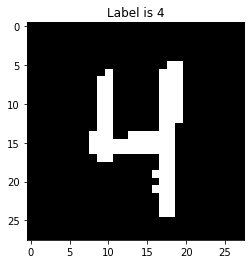

first mat dims torch.Size([784, 784])
last mat dims torch.Size([196, 10])
connecting layer 784 784
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 784 392
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 392 196
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connecting layer 196 10
connected 0 nodes in the layer
connected 100 nodes in the layer
starting to record
for 0 found 0 spikes 
for 1 found 0 spikes 
for 2 found 0 spikes 
for 3 found 21 spikes of

AttributeError: 'Net' object has no attribute 'logsoftmax'

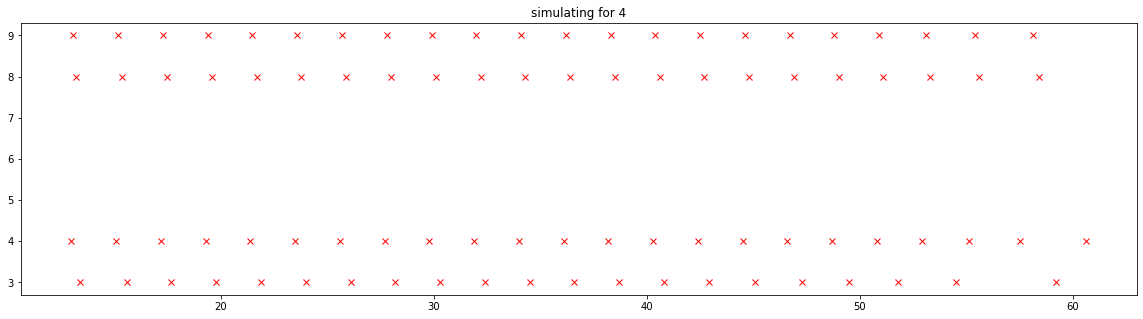

In [67]:
def Binarize(tensor, include_zero = False):
    if include_zero:
        N_std = 1
        up = (tensor>0 + N_std*tensor.std()).float()
        down = (tensor<0 - N_std*tensor.std()).float().mul(-1)
        return (up + down)
    else:
        return tensor.sign()

class BinarizeLinear(nn.Linear):

    def __init__(self, *kargs, **kwargs):
        super(BinarizeLinear, self).__init__(*kargs, **kwargs)

    def forward(self, input):

        if input.size(1) != 784:
            input.data=Binarize(input.data)
        if not hasattr(self.weight,'org'):
            self.weight.org=self.weight.data.clone()
        self.weight.data=Binarize(self.weight.org)
        out = nn.functional.linear(input, self.weight)
        if not self.bias is None:
            self.bias.org=self.bias.data.clone()
            out += self.bias.view(1, -1).expand_as(out)

        return out
    
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #self.cv1 = BinarizeConv2d(1, 8, 5, bias=False, stride=1, padding=2)
        #self.htanh0 = nn.Hardtanh()
        #self.mp = nn.MaxPool2d(kernel_size=2,stride=2)
        #self.cv2 = BinarizeConv2d(8, 16, 5, bias=False, stride=1, padding=2)
        #self.htanh01 = nn.Hardtanh()
        #self.mp2 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.fc1 = BinarizeLinear(784, 7*7*8, bias=False)
        self.htanh1 = nn.Hardtanh()
        self.bn1 = nn.BatchNorm1d(7*7*8)
        self.fc2 = BinarizeLinear(7*7*8, 7*7*4, bias=False)
        self.htanh2 = nn.Hardtanh()
        self.bn2 = nn.BatchNorm1d(7*7*4)
        self.fc3 = BinarizeLinear(7*7*4, 7*7*2, bias=False)
        self.htanh3 = nn.Hardtanh()
        self.bn3 = nn.BatchNorm1d(7*7*2)
        self.fc4 = BinarizeLinear(7*7*2, 10, bias=False)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.htanh1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.htanh2(x)
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.htanh3(x)
        x = self.fc4(x)
        return self.logsoftmax(x)
    
model = Net()
model.load_state_dict(torch.load("mnist_trained_with_binerized.pt",map_location=torch.device('cpu')))
model.eval()
testMNIST(model)

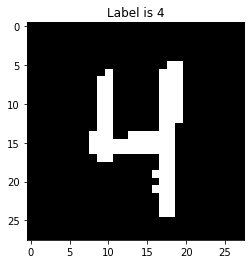

first mat dims torch.Size([784, 1568])
last mat dims torch.Size([50, 10])
connecting layer 784 1568
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 1568 784
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connected 800 nodes in the layer
connected 900 nodes in the layer
connected 1000 nodes in the layer
connected 1100 nodes in the layer
connected 1200 nodes in the layer
connected 1300 nodes in the layer
connected 1400 nodes in the layer
connected 1500 nodes in the layer
connecting layer 784 392
connected 0 nodes in the layer
connected 100 nodes in t

<ipython-input-66-8a69c9c483b5>:93: UserWarning:Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


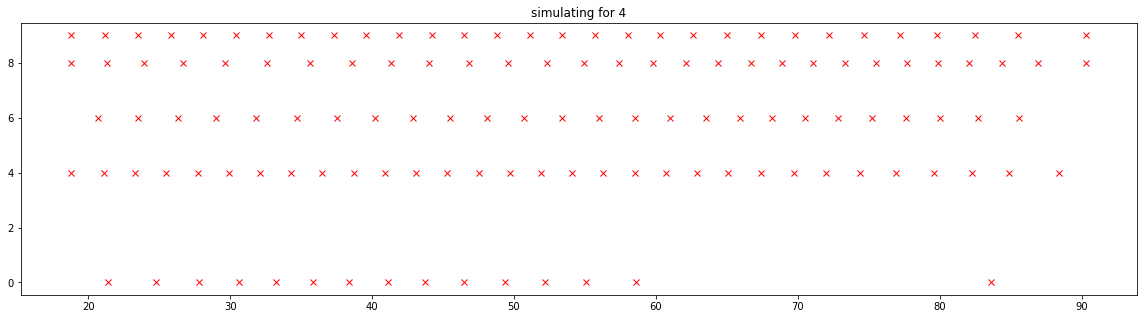

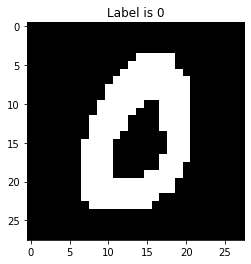

first mat dims torch.Size([784, 1568])
last mat dims torch.Size([50, 10])
connecting layer 784 1568
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 1568 784
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connected 800 nodes in the layer
connected 900 nodes in the layer
connected 1000 nodes in the layer
connected 1100 nodes in the layer
connected 1200 nodes in the layer
connected 1300 nodes in the layer
connected 1400 nodes in the layer
connected 1500 nodes in the layer
connecting layer 784 392
connected 0 nodes in the layer
connected 100 nodes in t

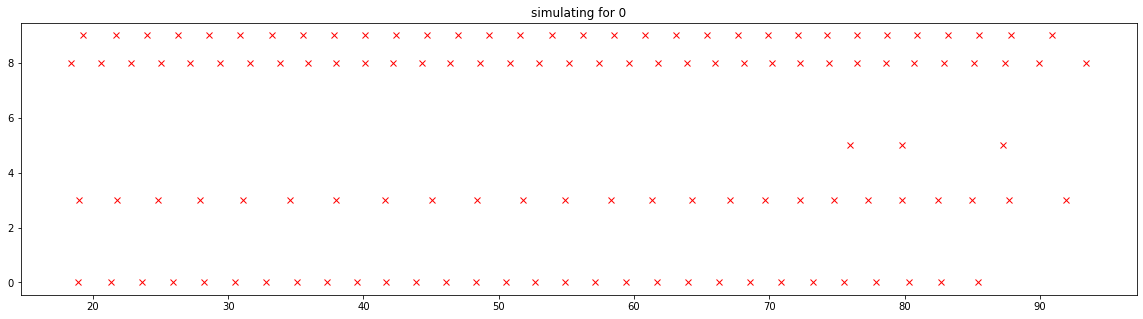

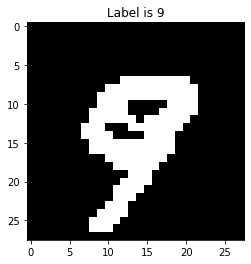

first mat dims torch.Size([784, 1568])
last mat dims torch.Size([50, 10])
connecting layer 784 1568
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 1568 784
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connected 800 nodes in the layer
connected 900 nodes in the layer
connected 1000 nodes in the layer
connected 1100 nodes in the layer
connected 1200 nodes in the layer
connected 1300 nodes in the layer
connected 1400 nodes in the layer
connected 1500 nodes in the layer
connecting layer 784 392
connected 0 nodes in the layer
connected 100 nodes in t

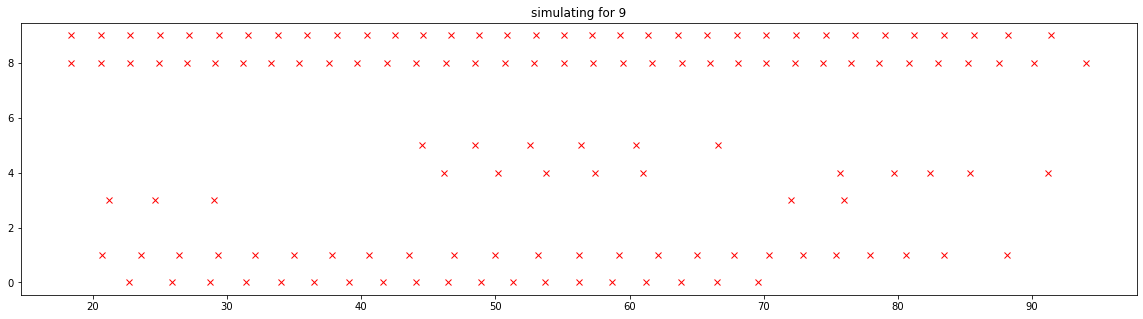

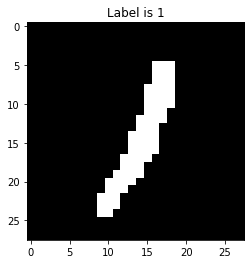

first mat dims torch.Size([784, 1568])
last mat dims torch.Size([50, 10])
connecting layer 784 1568
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 1568 784
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connected 800 nodes in the layer
connected 900 nodes in the layer
connected 1000 nodes in the layer
connected 1100 nodes in the layer
connected 1200 nodes in the layer
connected 1300 nodes in the layer
connected 1400 nodes in the layer
connected 1500 nodes in the layer
connecting layer 784 392
connected 0 nodes in the layer
connected 100 nodes in t

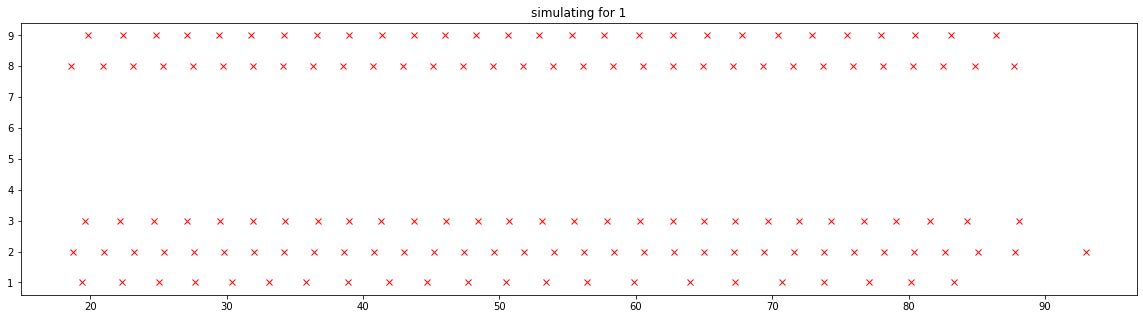

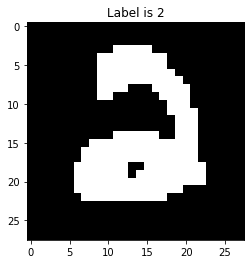

first mat dims torch.Size([784, 1568])
last mat dims torch.Size([50, 10])
connecting layer 784 1568
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 1568 784
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connected 800 nodes in the layer
connected 900 nodes in the layer
connected 1000 nodes in the layer
connected 1100 nodes in the layer
connected 1200 nodes in the layer
connected 1300 nodes in the layer
connected 1400 nodes in the layer
connected 1500 nodes in the layer
connecting layer 784 392
connected 0 nodes in the layer
connected 100 nodes in t

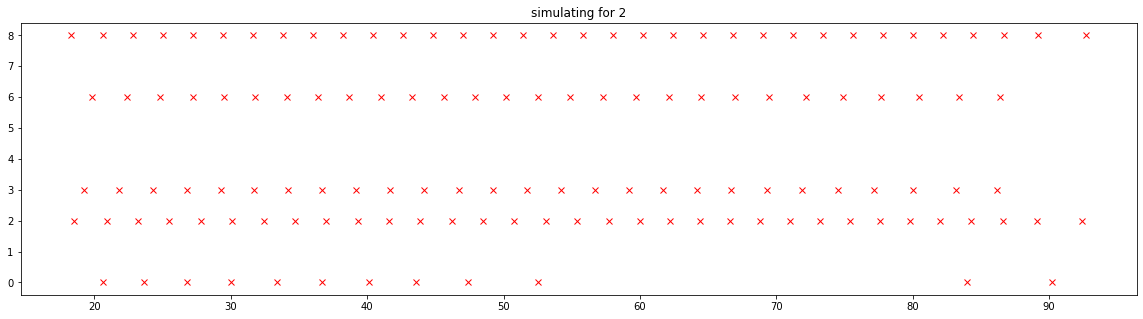

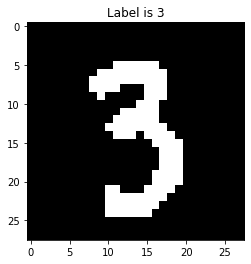

first mat dims torch.Size([784, 1568])
last mat dims torch.Size([50, 10])
connecting layer 784 1568
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 1568 784
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connected 800 nodes in the layer
connected 900 nodes in the layer
connected 1000 nodes in the layer
connected 1100 nodes in the layer
connected 1200 nodes in the layer
connected 1300 nodes in the layer
connected 1400 nodes in the layer
connected 1500 nodes in the layer
connecting layer 784 392
connected 0 nodes in the layer
connected 100 nodes in t

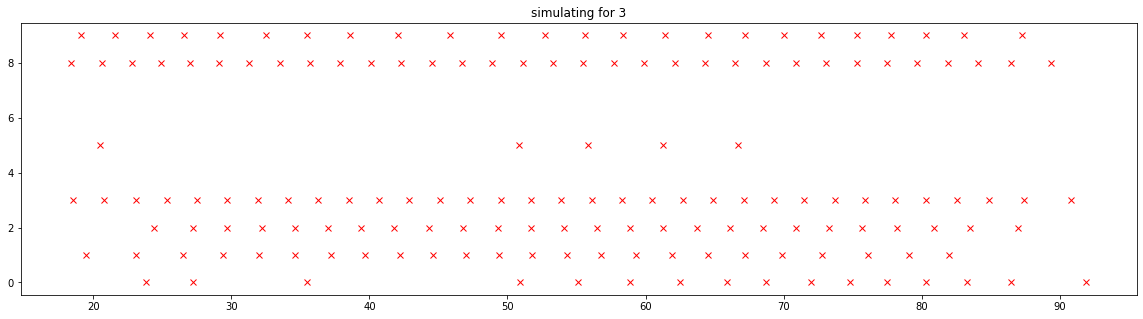

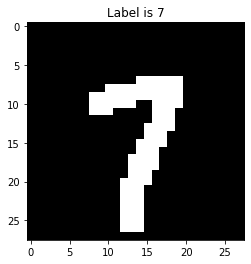

first mat dims torch.Size([784, 1568])
last mat dims torch.Size([50, 10])
connecting layer 784 1568
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 1568 784
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connected 800 nodes in the layer
connected 900 nodes in the layer
connected 1000 nodes in the layer
connected 1100 nodes in the layer
connected 1200 nodes in the layer
connected 1300 nodes in the layer
connected 1400 nodes in the layer
connected 1500 nodes in the layer
connecting layer 784 392
connected 0 nodes in the layer
connected 100 nodes in t

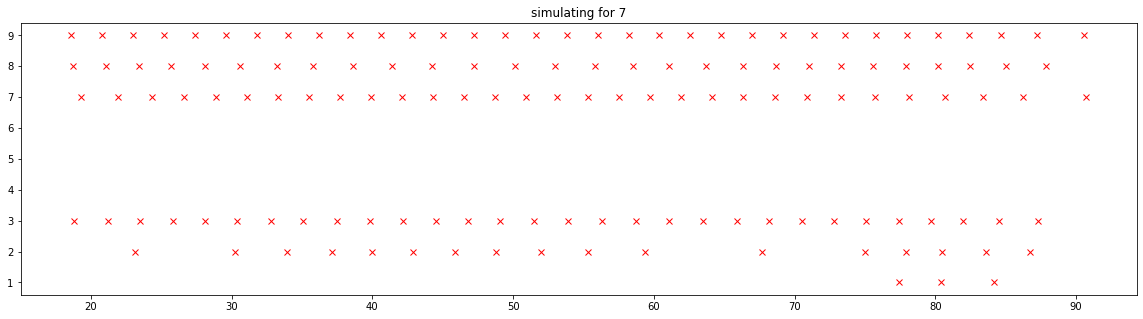

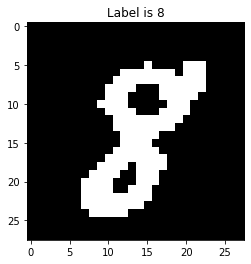

first mat dims torch.Size([784, 1568])
last mat dims torch.Size([50, 10])
connecting layer 784 1568
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 1568 784
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connected 800 nodes in the layer
connected 900 nodes in the layer
connected 1000 nodes in the layer
connected 1100 nodes in the layer
connected 1200 nodes in the layer
connected 1300 nodes in the layer
connected 1400 nodes in the layer
connected 1500 nodes in the layer
connecting layer 784 392
connected 0 nodes in the layer
connected 100 nodes in t

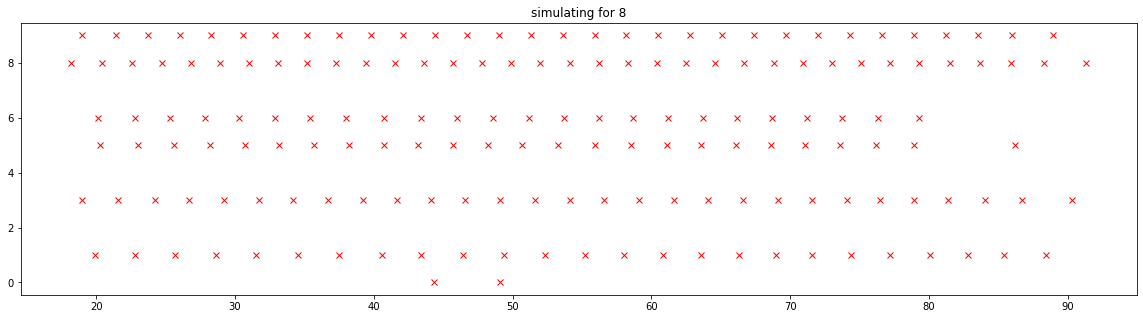

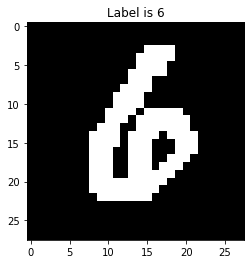

first mat dims torch.Size([784, 1568])
last mat dims torch.Size([50, 10])
connecting layer 784 1568
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 1568 784
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connected 800 nodes in the layer
connected 900 nodes in the layer
connected 1000 nodes in the layer
connected 1100 nodes in the layer
connected 1200 nodes in the layer
connected 1300 nodes in the layer
connected 1400 nodes in the layer
connected 1500 nodes in the layer
connecting layer 784 392
connected 0 nodes in the layer
connected 100 nodes in t

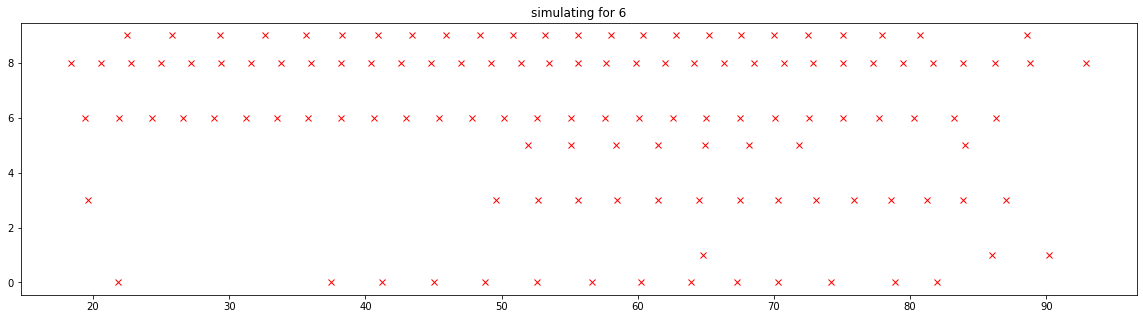

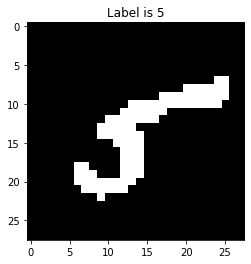

first mat dims torch.Size([784, 1568])
last mat dims torch.Size([50, 10])
connecting layer 784 1568
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 1568 784
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connected 800 nodes in the layer
connected 900 nodes in the layer
connected 1000 nodes in the layer
connected 1100 nodes in the layer
connected 1200 nodes in the layer
connected 1300 nodes in the layer
connected 1400 nodes in the layer
connected 1500 nodes in the layer
connecting layer 784 392
connected 0 nodes in the layer
connected 100 nodes in t

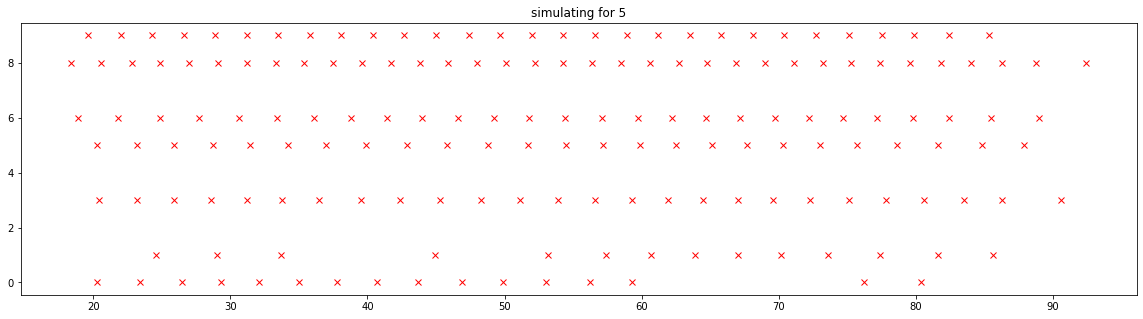

In [66]:
def Binarize(tensor, include_zero = False):
    if include_zero:
        N_std = 1
        up = (tensor>0 + N_std*tensor.std()).float()
        down = (tensor<0 - N_std*tensor.std()).float().mul(-1)
        return (up + down)
    else:
        return tensor.sign()

class BinarizeLinear(nn.Linear):

    def __init__(self, *kargs, **kwargs):
        super(BinarizeLinear, self).__init__(*kargs, **kwargs)

    def forward(self, input):

        if input.size(1) != 784:
            input.data=Binarize(input.data)
        if not hasattr(self.weight,'org'):
            self.weight.org=self.weight.data.clone()
        self.weight.data=Binarize(self.weight.org)
        out = nn.functional.linear(input, self.weight)
        if not self.bias is None:
            self.bias.org=self.bias.data.clone()
            out += self.bias.view(1, -1).expand_as(out)

        return out
    
class GaussianNoise(nn.Module):
    def __init__(self, sigma=0.1, is_relative_detach=True):
        super().__init__()
        self.sigma = sigma
        self.is_relative_detach = is_relative_detach
        self.noise = torch.tensor(0).float()

    def forward(self, x):
        if self.training and self.sigma != 0:
            scale = self.sigma * x.detach() if self.is_relative_detach else self.sigma * x
            sampled_noise = self.noise.repeat(*x.size()).normal_()
            sampled_noise = sampled_noise * scale
            x = x + sampled_noise
        return x


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = BinarizeLinear(784, 7*7*16, bias=False)
        self.htanh1 = nn.Hardtanh()
        self.bn1 = nn.BatchNorm1d(7*7*16)
        self.fc2 = BinarizeLinear(7*7*16, 7*7*8, bias=False)
        self.htanh2 = nn.Hardtanh()
        self.bn2 = nn.BatchNorm1d(7*7*8)
        self.fc3 = BinarizeLinear(7*7*8, 7*7*4, bias=False)
        self.htanh3 = nn.Hardtanh()
        self.bn3 = nn.BatchNorm1d(7*7*4)
        self.fc4 = BinarizeLinear(7*7*4, 7*7*2, bias=False)
        self.htanh4 = nn.Hardtanh()
        self.bn4 = nn.BatchNorm1d(7*7*2)
        self.fc5 = BinarizeLinear(7*7*2, 7*7, bias=False)
        self.htanh5 = nn.Hardtanh()
        self.bn5 = nn.BatchNorm1d(7*7)
        self.fc6 = BinarizeLinear(7*7, 25, bias=False)
        self.htanh6 = nn.Hardtanh()
        self.bn6 = nn.BatchNorm1d(25)
        self.gn = GaussianNoise()
        self.fc8 = BinarizeLinear(25, 10, bias=False)
        self.logsoftmax=nn.LogSoftmax()
        self.drop1=nn.Dropout(0.5)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.htanh1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.htanh2(x)
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.htanh3(x)
        x = self.fc4(x)
        x = self.bn4(x)
        x = self.htanh4(x)
        x = self.fc5(x)
        x = self.bn5(x)
        x = self.htanh5(x)
        x = self.fc6(x)
        x = self.bn6(x)
        x = self.htanh6(x)
        x = self.gn(x)
        x = self.fc8(x)
        return self.logsoftmax(x)
    
model = Net()
model.load_state_dict(torch.load("mnist_trained_with_noise.pt",map_location=torch.device('cpu')))
model.eval()
testMNIST(model)

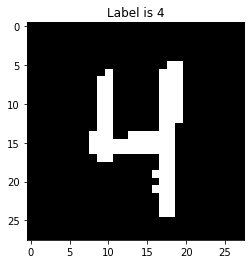

first mat dims torch.Size([784, 784])
last mat dims torch.Size([196, 10])
connecting layer 784 784
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 784 392
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 392 196
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connecting layer 196 10
connected 0 nodes in the layer
connected 100 nodes in the layer
starting to record
for 0 found 0 spikes 
for 1 found 0 spikes 
for 2 found 0 spikes 
for 3 found 0 spikes 
fo

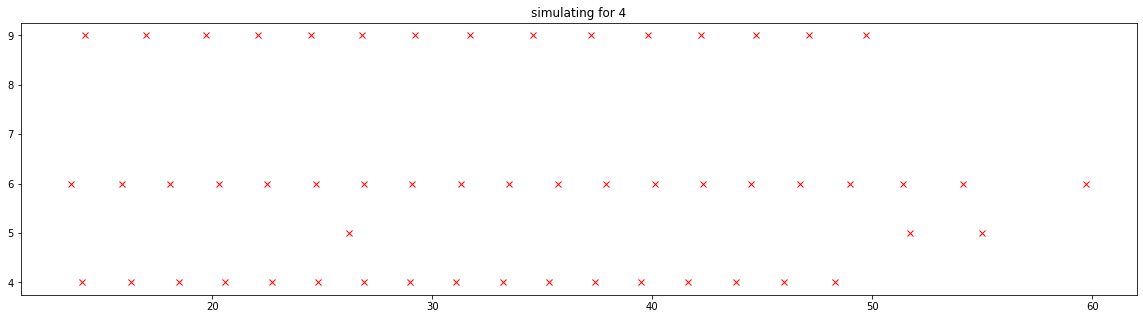

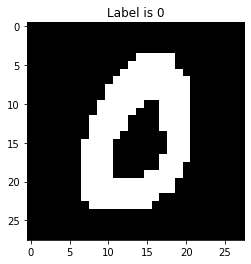

first mat dims torch.Size([784, 784])
last mat dims torch.Size([196, 10])
connecting layer 784 784
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 784 392
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 392 196
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connecting layer 196 10
connected 0 nodes in the layer
connected 100 nodes in the layer
starting to record
for 0 found 20 spikes of frequency 2.3578947368421055
for 1 found 0 spikes 
for 2 found 6 

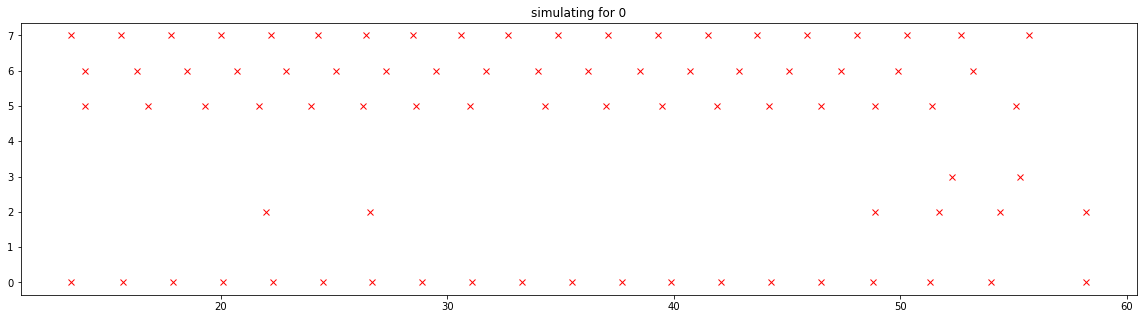

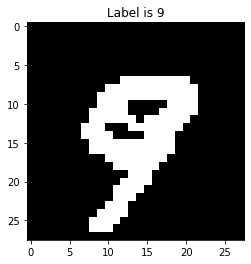

first mat dims torch.Size([784, 784])
last mat dims torch.Size([196, 10])
connecting layer 784 784
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 784 392
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 392 196
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connecting layer 196 10
connected 0 nodes in the layer
connected 100 nodes in the layer
starting to record
for 0 found 0 spikes 
for 1 found 0 spikes 
for 2 found 0 spikes 
for 3 found 0 spikes 
fo

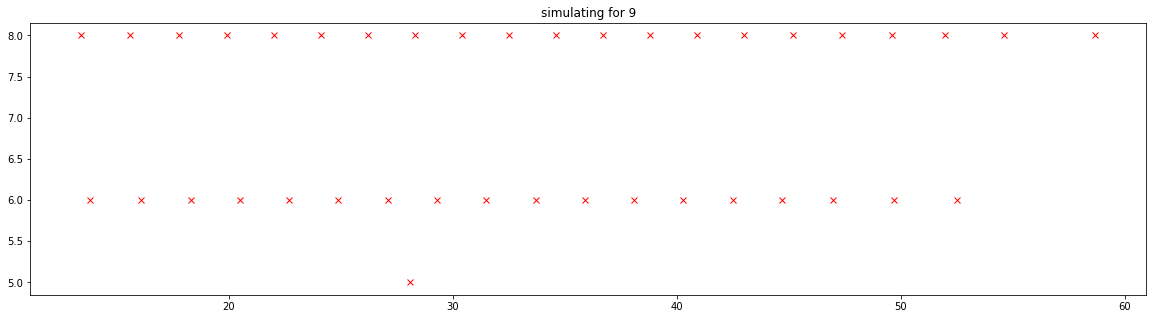

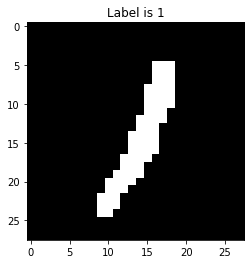

first mat dims torch.Size([784, 784])
last mat dims torch.Size([196, 10])
connecting layer 784 784
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 784 392
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 392 196
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connecting layer 196 10
connected 0 nodes in the layer
connected 100 nodes in the layer
starting to record
for 0 found 19 spikes of frequency 2.316666666666667
for 1 found 18 spikes of frequency 2.

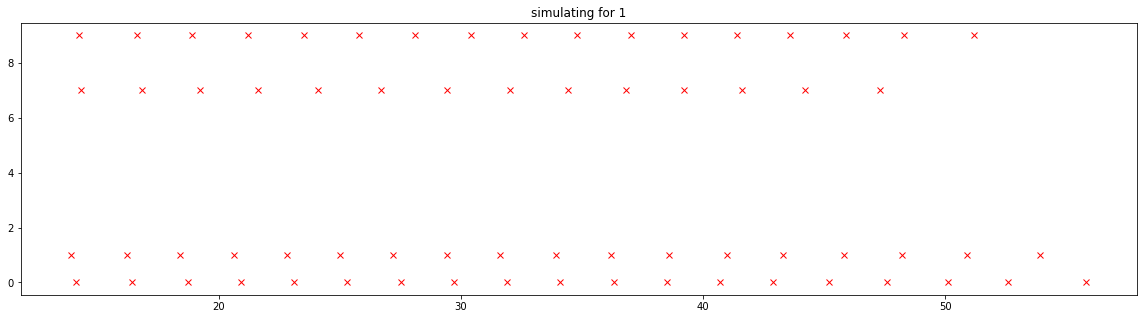

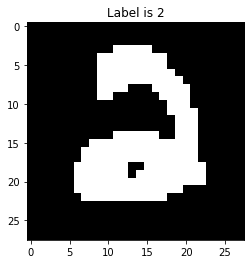

first mat dims torch.Size([784, 784])
last mat dims torch.Size([196, 10])
connecting layer 784 784
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 784 392
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 392 196
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connecting layer 196 10
connected 0 nodes in the layer
connected 100 nodes in the layer
starting to record
for 0 found 0 spikes 
for 1 found 0 spikes 
for 2 found 18 spikes of frequency 2.588235294

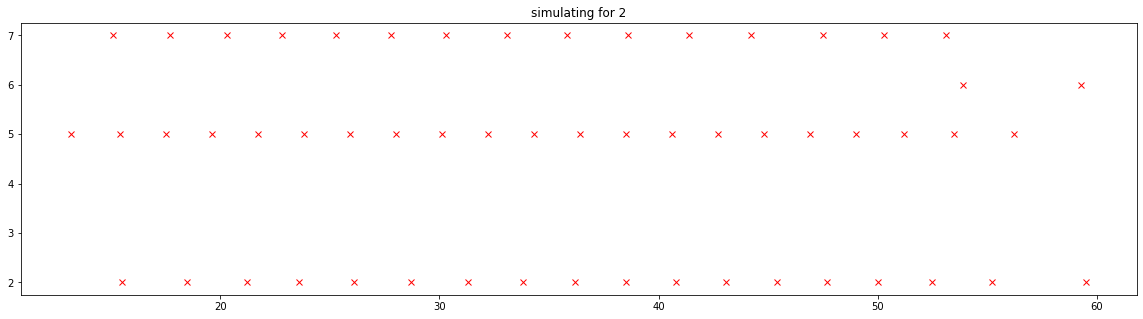

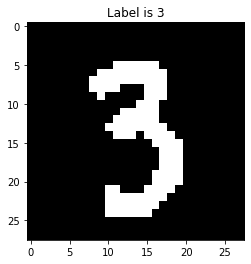

first mat dims torch.Size([784, 784])
last mat dims torch.Size([196, 10])
connecting layer 784 784
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 784 392
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 392 196
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connecting layer 196 10
connected 0 nodes in the layer
connected 100 nodes in the layer
starting to record
for 0 found 20 spikes of frequency 2.294736842105263
for 1 found 0 spikes 
for 2 found 0 s

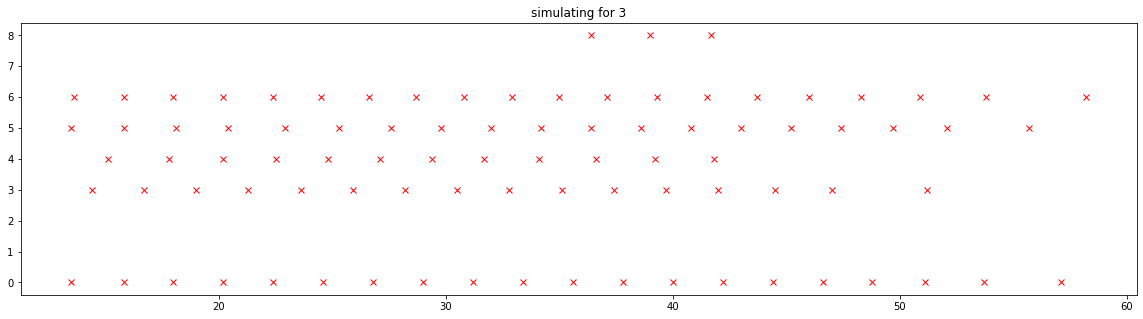

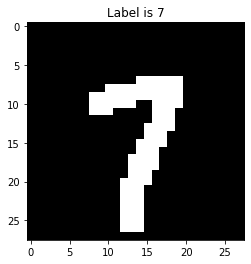

first mat dims torch.Size([784, 784])
last mat dims torch.Size([196, 10])
connecting layer 784 784
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 784 392
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 392 196
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connecting layer 196 10
connected 0 nodes in the layer
connected 100 nodes in the layer
starting to record
for 0 found 18 spikes of frequency 2.335294117647059
for 1 found 0 spikes 
for 2 found 0 s

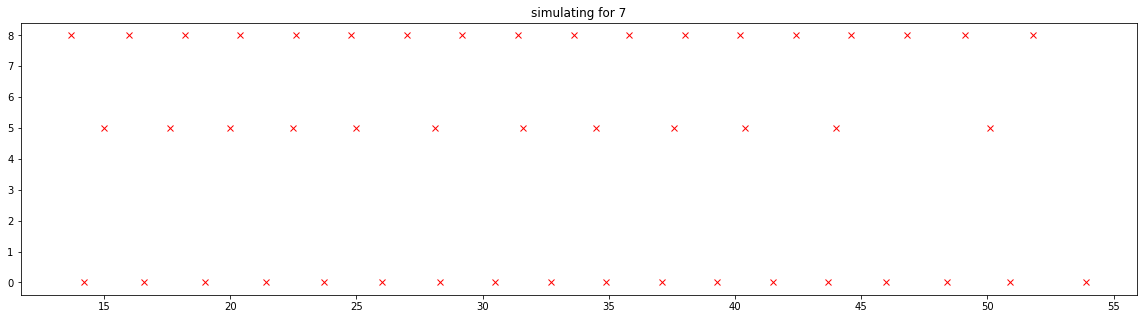

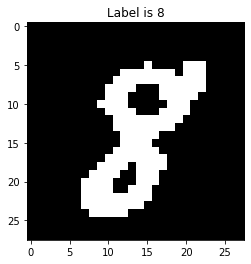

first mat dims torch.Size([784, 784])
last mat dims torch.Size([196, 10])
connecting layer 784 784
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 784 392
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 392 196
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connecting layer 196 10
connected 0 nodes in the layer
connected 100 nodes in the layer
starting to record
for 0 found 19 spikes of frequency 2.3277777777777775
for 1 found 19 spikes of frequency 2

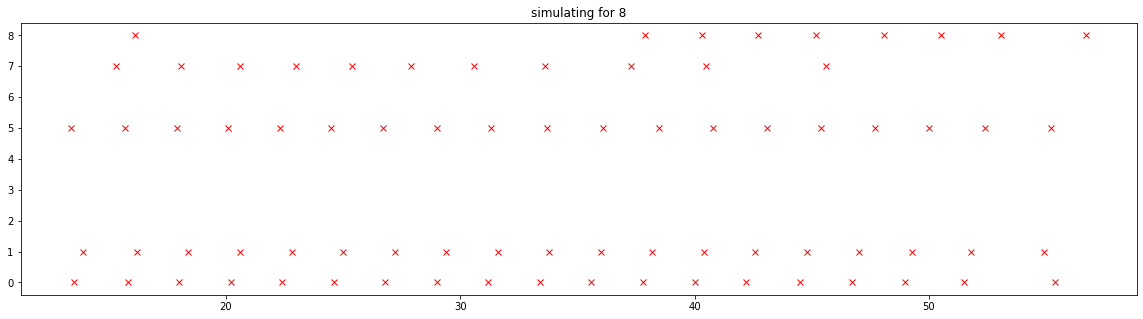

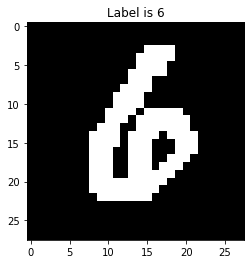

first mat dims torch.Size([784, 784])
last mat dims torch.Size([196, 10])
connecting layer 784 784
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 784 392
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 392 196
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connecting layer 196 10
connected 0 nodes in the layer
connected 100 nodes in the layer
starting to record
for 0 found 0 spikes 
for 1 found 0 spikes 
for 2 found 19 spikes of frequency 2.311111111

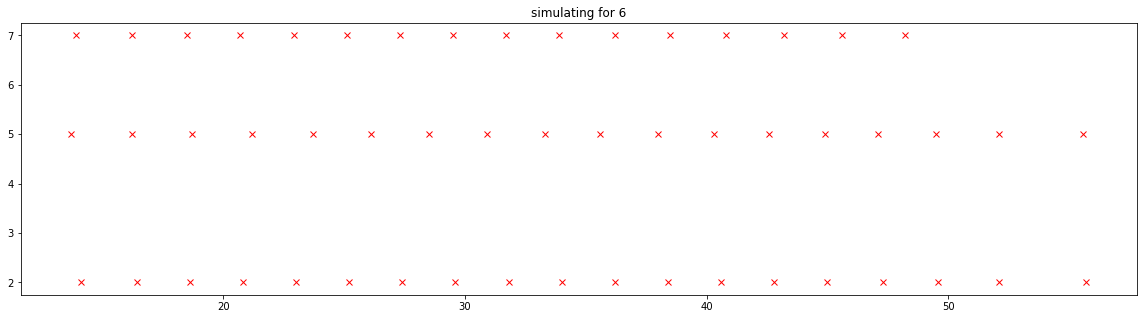

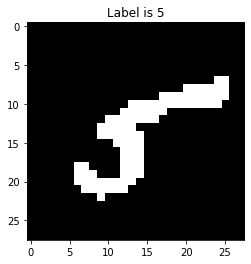

first mat dims torch.Size([784, 784])
last mat dims torch.Size([196, 10])
connecting layer 784 784
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 784 392
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 392 196
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connecting layer 196 10
connected 0 nodes in the layer
connected 100 nodes in the layer
starting to record
for 0 found 21 spikes of frequency 2.1950000000000003
for 1 found 0 spikes 
for 2 found 16

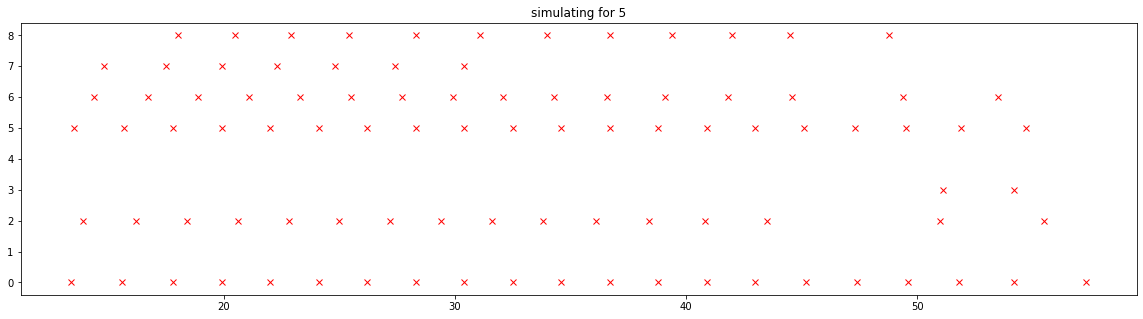

In [65]:
def Binarize(tensor, include_zero = False):
    if include_zero:
        N_std = 1
        up = (tensor>0 + N_std*tensor.std()).float()
        down = (tensor<0 - N_std*tensor.std()).float().mul(-1)
        return (up + down)
    else:
        return tensor.sign()

class BinarizeLinear(nn.Linear):

    def __init__(self, *kargs, **kwargs):
        super(BinarizeLinear, self).__init__(*kargs, **kwargs)

    def forward(self, input):

        if input.size(1) != 784:
            input.data=Binarize(input.data)
        if not hasattr(self.weight,'org'):
            self.weight.org=self.weight.data.clone()
        self.weight.data=Binarize(self.weight.org)
        out = nn.functional.linear(input, self.weight)
        if not self.bias is None:
            self.bias.org=self.bias.data.clone()
            out += self.bias.view(1, -1).expand_as(out)

        return out

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = BinarizeLinear(784, 7*7*8, bias=False)
        self.htanh1 = nn.Hardtanh()
        self.bn1 = nn.BatchNorm1d(7*7*8)
        self.fc2 = BinarizeLinear(7*7*8, 7*7*4, bias=False)
        self.htanh2 = nn.Hardtanh()
        self.bn2 = nn.BatchNorm1d(7*7*4)
        self.fc3 = BinarizeLinear(7*7*4, 7*7*2, bias=False)
        self.htanh3 = nn.Hardtanh()
        self.bn3 = nn.BatchNorm1d(7*7*2)
        self.fc4 = BinarizeLinear(7*7*2, 10, bias=False)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.htanh1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.htanh2(x)
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.htanh3(x)
        x = self.fc4(x)
        return x
    
model = Net()
model.load_state_dict(torch.load("mnist_trained_with_test.pt",map_location=torch.device('cpu')))
model.eval()
testMNIST(model)

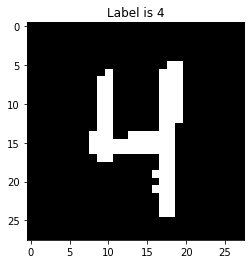

first mat dims torch.Size([784, 784])
last mat dims torch.Size([196, 10])
connecting layer 784 784
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 784 392
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 392 196
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connecting layer 196 10
connected 0 nodes in the layer
connected 100 nodes in the layer
starting to record
for 0 found 0 spikes 
for 1 found 0 spikes 
for 2 found 0 spikes 
for 3 found 3 spikes of 

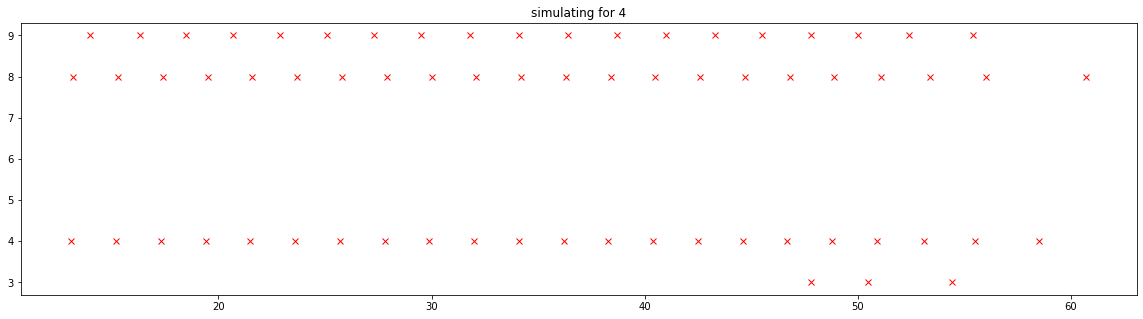

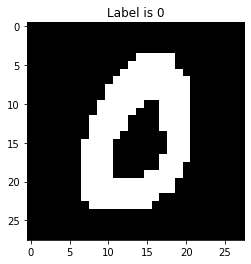

first mat dims torch.Size([784, 784])
last mat dims torch.Size([196, 10])
connecting layer 784 784
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 784 392
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 392 196
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connecting layer 196 10
connected 0 nodes in the layer
connected 100 nodes in the layer
starting to record
for 0 found 22 spikes of frequency 2.1476190476190475
for 1 found 0 spikes 
for 2 found 0 

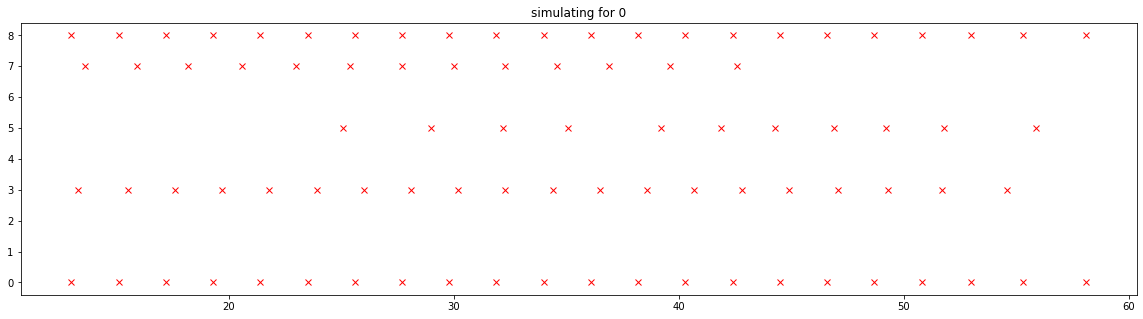

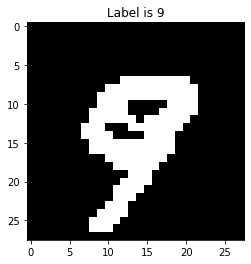

first mat dims torch.Size([784, 784])
last mat dims torch.Size([196, 10])
connecting layer 784 784
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 784 392
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 392 196
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connecting layer 196 10
connected 0 nodes in the layer
connected 100 nodes in the layer
starting to record
for 0 found 0 spikes 
for 1 found 0 spikes 
for 2 found 7 spikes of frequency 4.8166666666

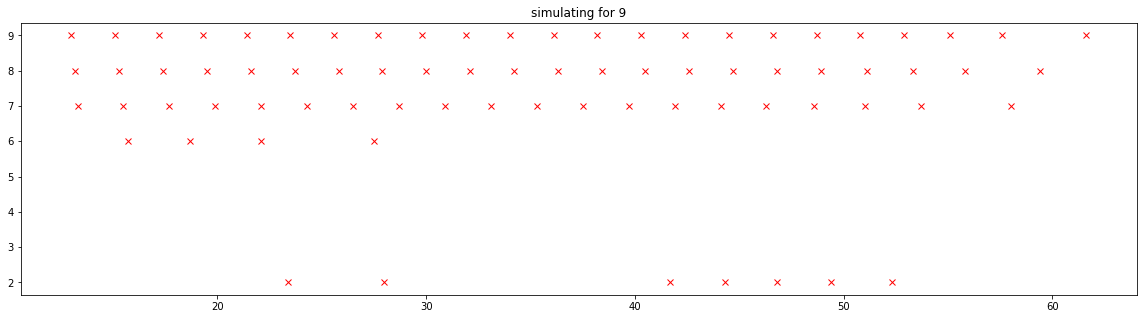

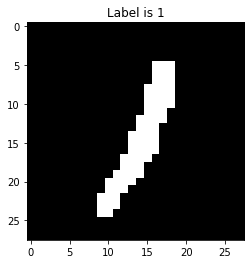

first mat dims torch.Size([784, 784])
last mat dims torch.Size([196, 10])
connecting layer 784 784
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 784 392
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 392 196
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connecting layer 196 10
connected 0 nodes in the layer
connected 100 nodes in the layer
starting to record
for 0 found 0 spikes 
for 1 found 21 spikes of frequency 2.1799999999999997
for 2 found 21

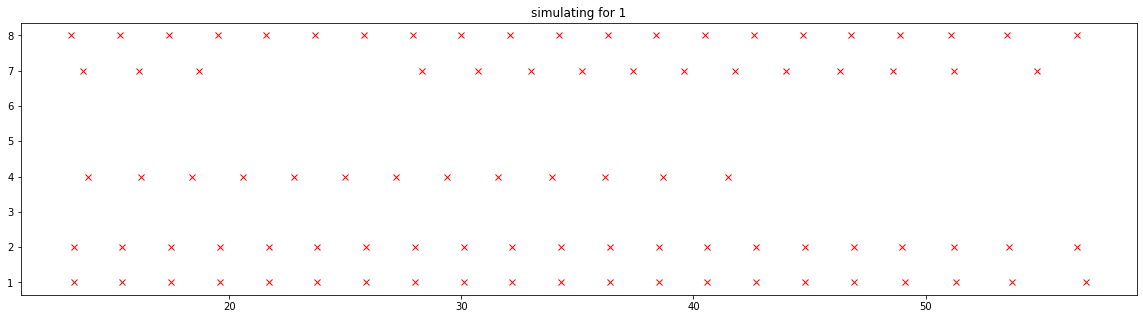

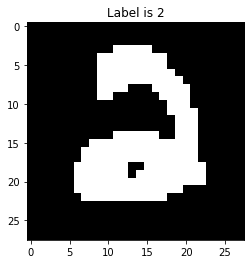

first mat dims torch.Size([784, 784])
last mat dims torch.Size([196, 10])
connecting layer 784 784
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 784 392
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 392 196
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connecting layer 196 10
connected 0 nodes in the layer
connected 100 nodes in the layer
starting to record
for 0 found 0 spikes 
for 1 found 0 spikes 
for 2 found 23 spikes of frequency 2.163636363

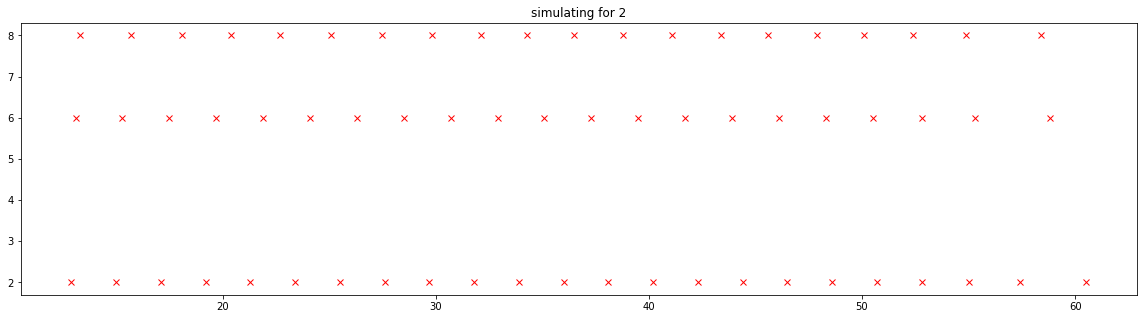

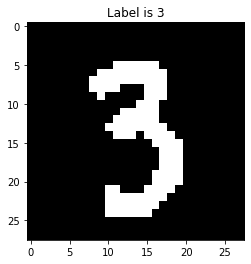

first mat dims torch.Size([784, 784])
last mat dims torch.Size([196, 10])
connecting layer 784 784
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 784 392
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 392 196
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connecting layer 196 10
connected 0 nodes in the layer
connected 100 nodes in the layer
starting to record
for 0 found 0 spikes 
for 1 found 0 spikes 
for 2 found 0 spikes 
for 3 found 23 spikes of

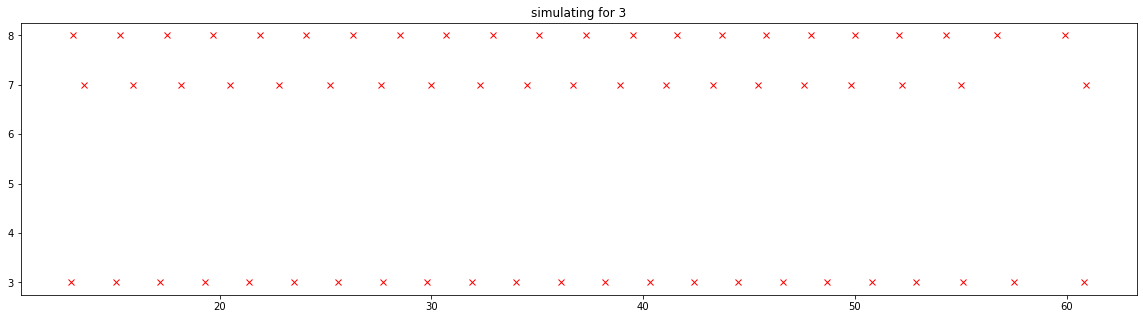

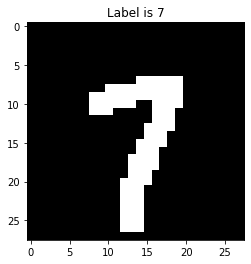

first mat dims torch.Size([784, 784])
last mat dims torch.Size([196, 10])
connecting layer 784 784
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 784 392
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 392 196
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connecting layer 196 10
connected 0 nodes in the layer
connected 100 nodes in the layer
starting to record
for 0 found 0 spikes 
for 1 found 0 spikes 
for 2 found 0 spikes 
for 3 found 0 spikes 
fo

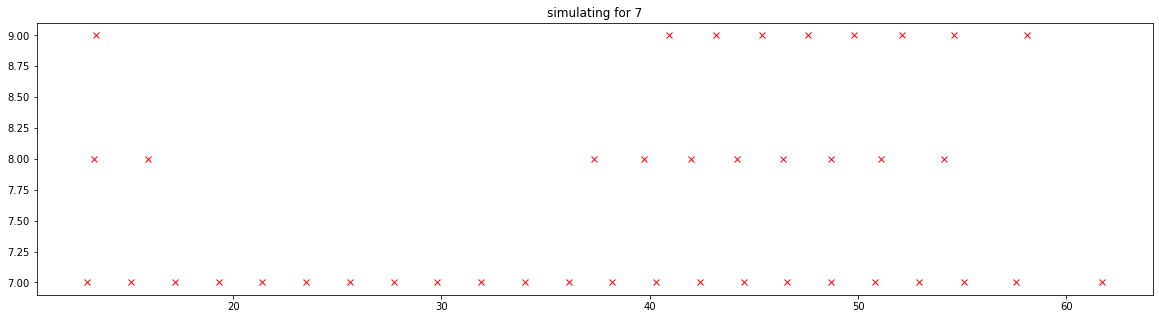

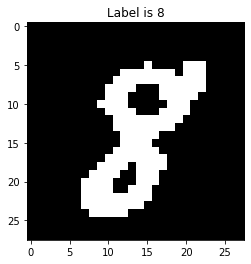

first mat dims torch.Size([784, 784])
last mat dims torch.Size([196, 10])
connecting layer 784 784
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 784 392
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 392 196
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connecting layer 196 10
connected 0 nodes in the layer
connected 100 nodes in the layer
starting to record
for 0 found 0 spikes 
for 1 found 0 spikes 
for 2 found 11 spikes of frequency 2.71
for 3 

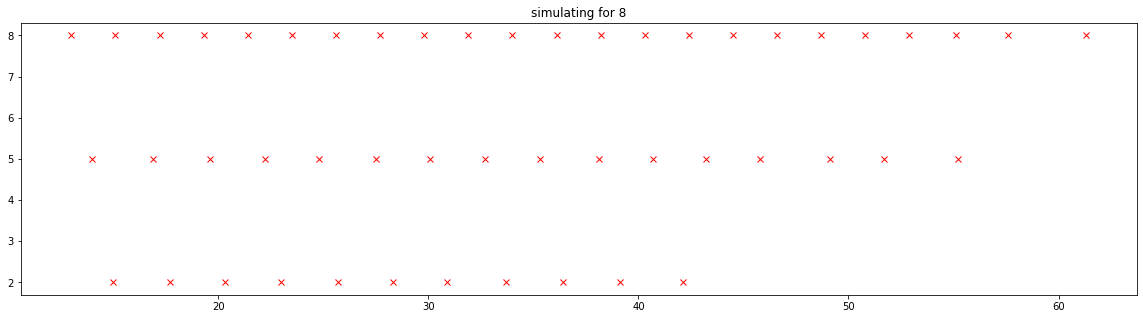

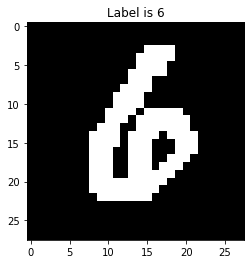

first mat dims torch.Size([784, 784])
last mat dims torch.Size([196, 10])
connecting layer 784 784
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 784 392
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 392 196
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connecting layer 196 10
connected 0 nodes in the layer
connected 100 nodes in the layer
starting to record
for 0 found 0 spikes 
for 1 found 0 spikes 
for 2 found 17 spikes of frequency 2.487500000

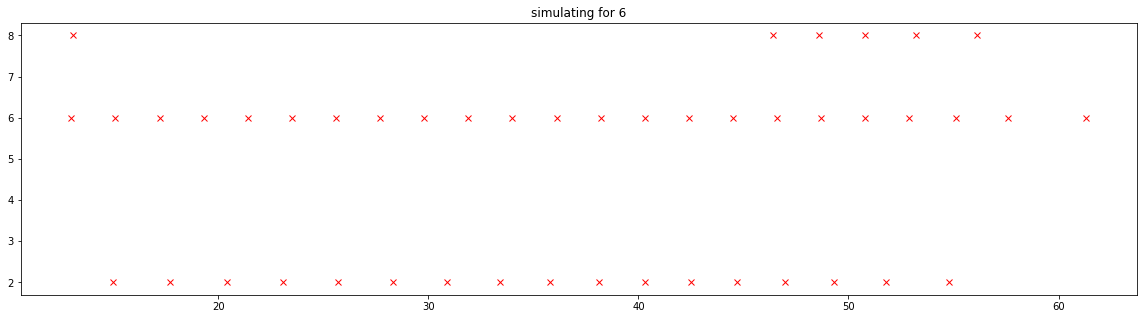

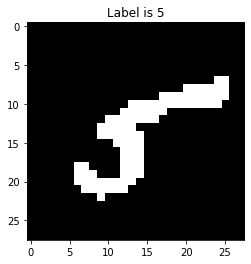

first mat dims torch.Size([784, 784])
last mat dims torch.Size([196, 10])
connecting layer 784 784
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 784 392
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 392 196
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connecting layer 196 10
connected 0 nodes in the layer
connected 100 nodes in the layer
starting to record
for 0 found 0 spikes 
for 1 found 0 spikes 
for 2 found 20 spikes of frequency 2.173684210

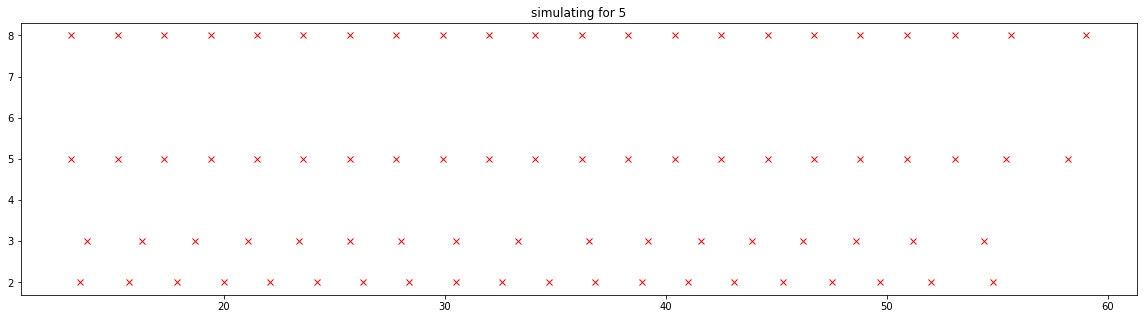

In [64]:
def Binarize(tensor, include_zero = False):
    if include_zero:
        N_std = 1
        up = (tensor>0 + N_std*tensor.std()).float()
        down = (tensor<0 - N_std*tensor.std()).float().mul(-1)
        return (up + down)
    else:
        return tensor.sign()

class BinarizeLinear(nn.Linear):

    def __init__(self, *kargs, **kwargs):
        super(BinarizeLinear, self).__init__(*kargs, **kwargs)

    def forward(self, input):

        if input.size(1) != 784:
            input.data=Binarize(input.data)
        if not hasattr(self.weight,'org'):
            self.weight.org=self.weight.data.clone()
        self.weight.data=Binarize(self.weight.org)
        out = nn.functional.linear(input, self.weight)
        if not self.bias is None:
            self.bias.org=self.bias.data.clone()
            out += self.bias.view(1, -1).expand_as(out)

        return out

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = BinarizeLinear(784, 7*7*8, bias=False)
        self.htanh1 = nn.Hardtanh()
        self.bn1 = nn.BatchNorm1d(7*7*8)
        self.fc2 = BinarizeLinear(7*7*8, 7*7*4, bias=False)
        self.htanh2 = nn.Hardtanh()
        self.bn2 = nn.BatchNorm1d(7*7*4)
        self.fc3 = BinarizeLinear(7*7*4, 7*7*2, bias=False)
        self.htanh3 = nn.Hardtanh()
        self.bn3 = nn.BatchNorm1d(7*7*2)
        self.fc4 = BinarizeLinear(7*7*2, 10, bias=False)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.htanh1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.htanh2(x)
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.htanh3(x)
        x = self.fc4(x)
        return x
    
model = Net()
model.load_state_dict(torch.load("mnist_trained_with_crossentropy.pt",map_location=torch.device('cpu')))
model.eval()
testMNIST(model)

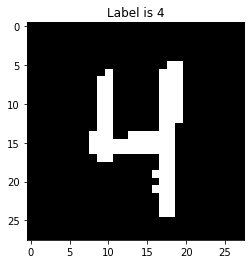

first mat dims torch.Size([784, 100])
last mat dims torch.Size([100, 10])
connecting layer 784 100
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 100 10
connected 0 nodes in the layer
starting to record
for 0 found 0 spikes 
for 1 found 0 spikes 
for 2 found 0 spikes 
for 3 found 4 spikes of frequency 4.266666666666667
for 4 found 10 spikes of frequency 2.4444444444444446
for 5 found 0 spikes 
for 6 found 8 spikes of frequency 2.457142857142857
for 7 found 0 spikes 
for 8 found 0 spikes 
for 9 found 9 spikes of frequency 2.4000000000000004
ANN result: tensor([[-16., -14.,  -4.,   2.,  30., -12.,   4.,   0.,  -6.,  16.]],
       grad_fn=<MmBackward>)
simulation result:


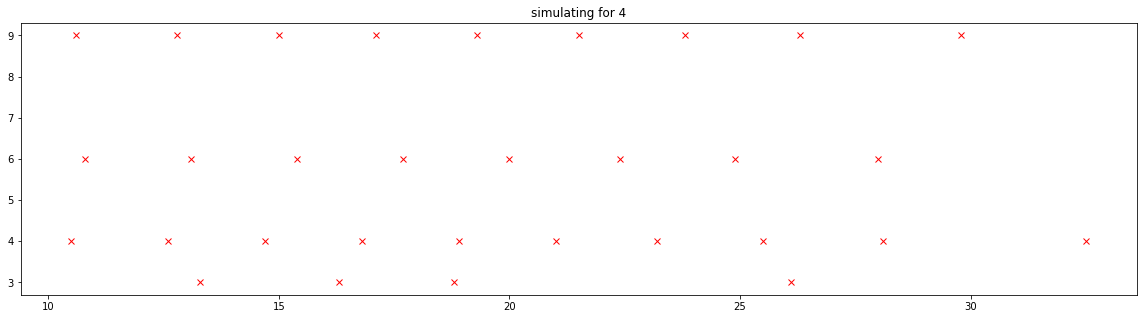

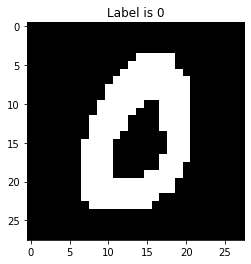

first mat dims torch.Size([784, 100])
last mat dims torch.Size([100, 10])
connecting layer 784 100
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 100 10
connected 0 nodes in the layer
starting to record
for 0 found 10 spikes of frequency 2.2222222222222223
for 1 found 0 spikes 
for 2 found 1 spikes 
for 3 found 0 spikes 
for 4 found 0 spikes 
for 5 found 6 spikes of frequency 2.7600000000000002
for 6 found 1 spikes 
for 7 found 5 spikes of frequency 2.4250000000000003
for 8 found 6 spikes of frequency 3.12
for 9 found 7 spikes of frequency 2.3666666666666667
ANN result: tensor([[ 24., -26.,   0., -10.,  -6.,   0.,   0.,   8.,   2.,  12.]],
       grad_fn=<MmBackward>)
simulation result:


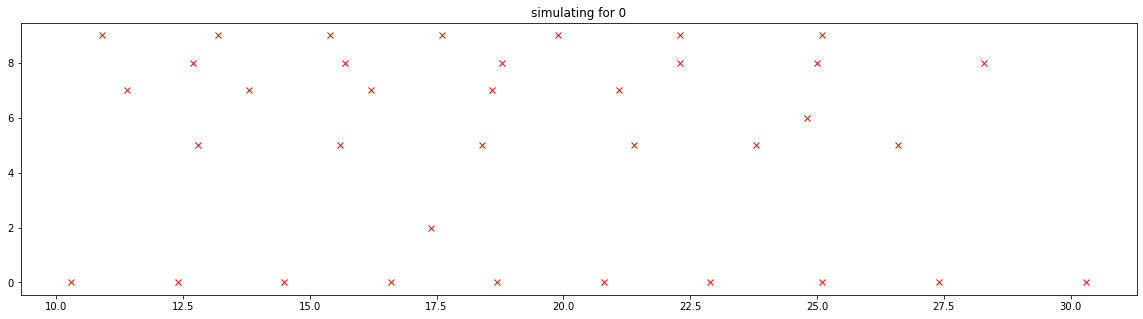

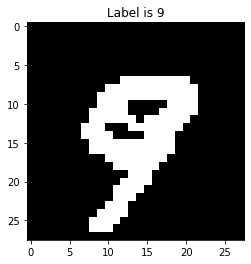

first mat dims torch.Size([784, 100])
last mat dims torch.Size([100, 10])
connecting layer 784 100
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 100 10
connected 0 nodes in the layer
starting to record
for 0 found 0 spikes 
for 1 found 0 spikes 
for 2 found 0 spikes 
for 3 found 0 spikes 
for 4 found 9 spikes of frequency 2.325
for 5 found 0 spikes 
for 6 found 1 spikes 
for 7 found 9 spikes of frequency 2.2875
for 8 found 5 spikes of frequency 2.5500000000000003
for 9 found 10 spikes of frequency 2.2444444444444445
ANN result: tensor([[-10.,  -2.,  -2., -10.,  10., -14.,   0.,  18.,   4.,  30.]],
       grad_fn=<MmBackward>)
simulation result:


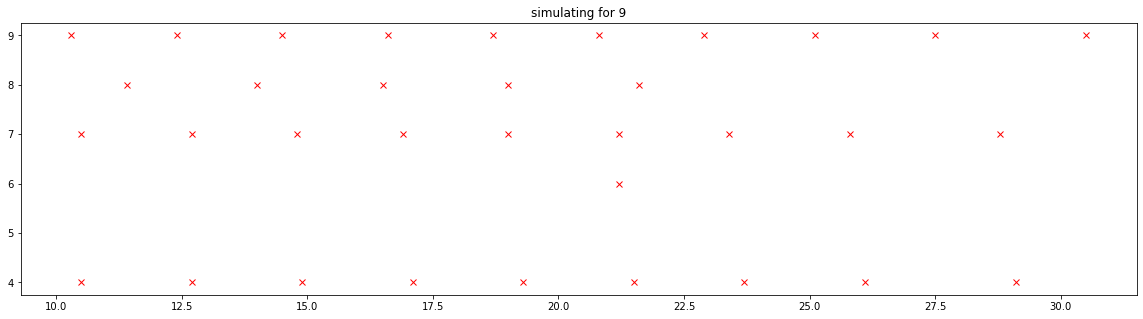

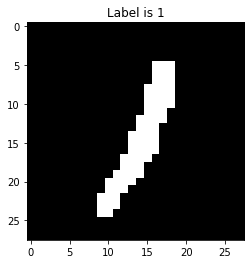

first mat dims torch.Size([784, 100])
last mat dims torch.Size([100, 10])
connecting layer 784 100
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 100 10
connected 0 nodes in the layer
starting to record
for 0 found 0 spikes 
for 1 found 10 spikes of frequency 2.577777777777778
for 2 found 7 spikes of frequency 2.5500000000000003
for 3 found 0 spikes 
for 4 found 5 spikes of frequency 2.55
for 5 found 0 spikes 
for 6 found 3 spikes of frequency 3.3999999999999995
for 7 found 6 spikes of frequency 3.72
for 8 found 5 spikes of frequency 3.225
for 9 found 3 spikes of frequency 3.95
ANN result: tensor([[-26.,  24.,   2.,  -4.,   8., -10.,   6.,  -2.,   4.,   2.]],
       grad_fn=<MmBackward>)
simulation result:


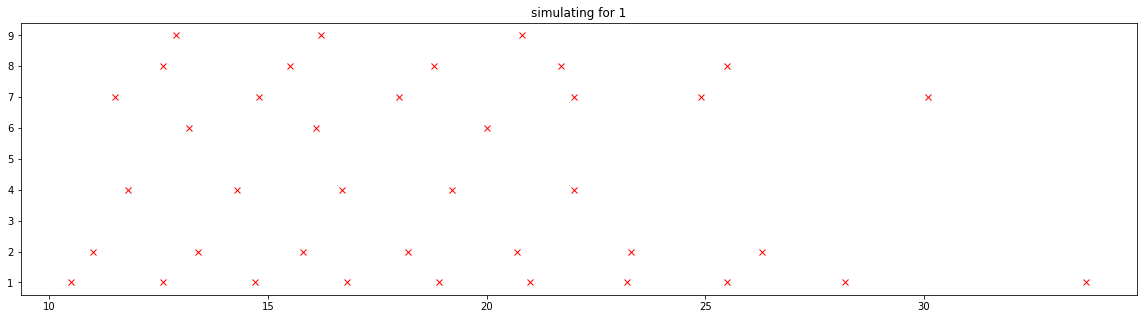

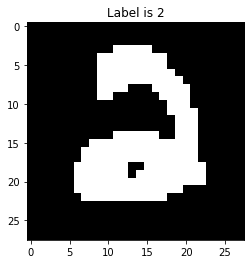

first mat dims torch.Size([784, 100])
last mat dims torch.Size([100, 10])
connecting layer 784 100
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 100 10
connected 0 nodes in the layer
starting to record
for 0 found 8 spikes of frequency 2.6714285714285717
for 1 found 0 spikes 
for 2 found 11 spikes of frequency 2.4699999999999998
for 3 found 0 spikes 
for 4 found 0 spikes 
for 5 found 0 spikes 
for 6 found 9 spikes of frequency 2.3500000000000005
for 7 found 0 spikes 
for 8 found 0 spikes 
for 9 found 0 spikes 
ANN result: tensor([[ 3., -5., 33., -1.,  1., -3.,  9., -9., -5., -3.]],
       grad_fn=<MmBackward>)
simulation result:


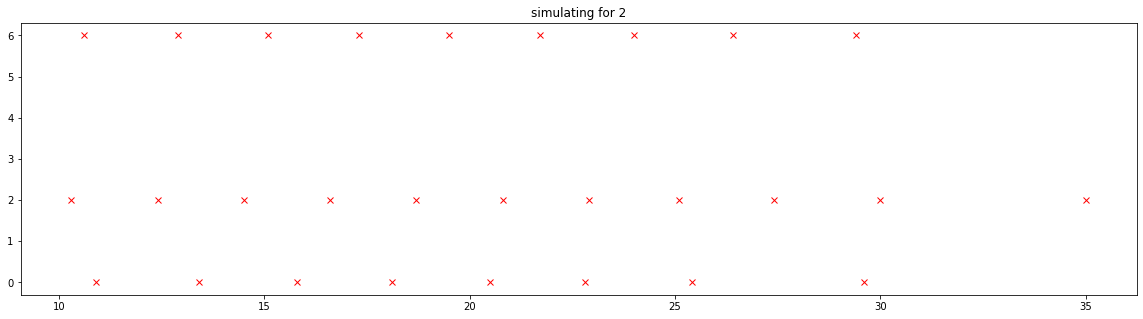

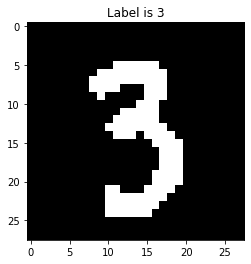

first mat dims torch.Size([784, 100])
last mat dims torch.Size([100, 10])
connecting layer 784 100
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 100 10
connected 0 nodes in the layer
starting to record
for 0 found 0 spikes 
for 1 found 0 spikes 
for 2 found 0 spikes 
for 3 found 10 spikes of frequency 2.2444444444444445
for 4 found 0 spikes 
for 5 found 9 spikes of frequency 2.4625000000000004
for 6 found 0 spikes 
for 7 found 0 spikes 
for 8 found 4 spikes of frequency 2.666666666666666
for 9 found 6 spikes of frequency 2.82
ANN result: tensor([[ -8.,  -2.,  -4.,  30.,  -6.,  16., -16.,  -4.,   6.,   4.]],
       grad_fn=<MmBackward>)
simulation result:


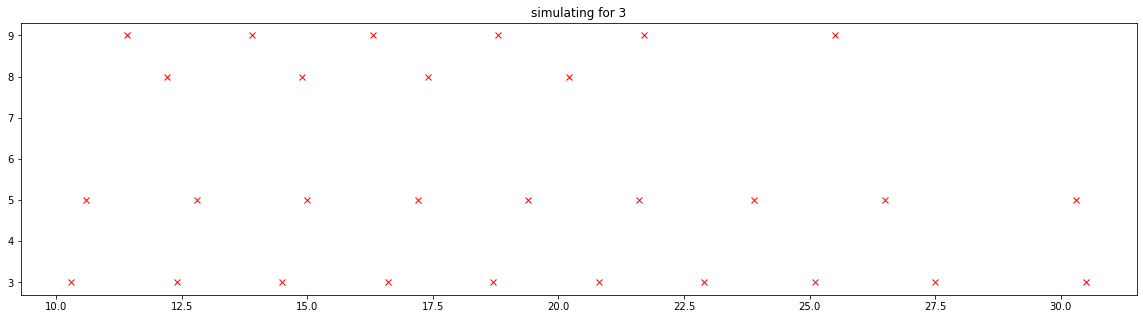

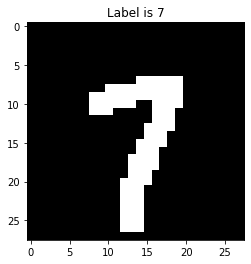

first mat dims torch.Size([784, 100])
last mat dims torch.Size([100, 10])
connecting layer 784 100
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 100 10
connected 0 nodes in the layer
starting to record
for 0 found 0 spikes 
for 1 found 0 spikes 
for 2 found 2 spikes of frequency 4.699999999999999
for 3 found 0 spikes 
for 4 found 0 spikes 
for 5 found 0 spikes 
for 6 found 0 spikes 
for 7 found 10 spikes of frequency 2.2444444444444445
for 8 found 0 spikes 
for 9 found 9 spikes of frequency 2.45
ANN result: tensor([[ -3.,  -7.,   3., -13., -11., -19., -17.,  37.,  -5.,  11.]],
       grad_fn=<MmBackward>)
simulation result:


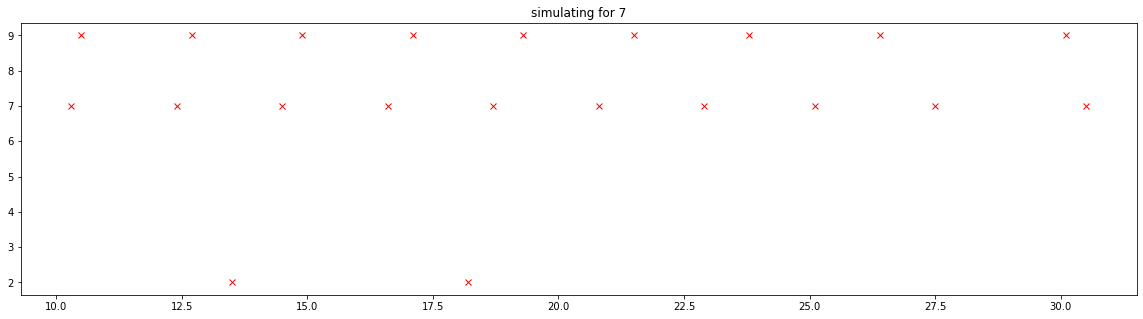

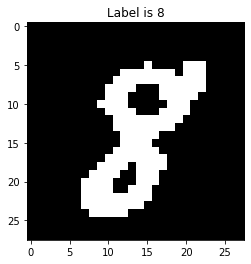

first mat dims torch.Size([784, 100])
last mat dims torch.Size([100, 10])
connecting layer 784 100
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 100 10
connected 0 nodes in the layer
starting to record
for 0 found 0 spikes 
for 1 found 7 spikes of frequency 3.1999999999999997
for 2 found 0 spikes 
for 3 found 2 spikes of frequency 3.5
for 4 found 0 spikes 
for 5 found 7 spikes of frequency 2.4166666666666665
for 6 found 0 spikes 
for 7 found 0 spikes 
for 8 found 10 spikes of frequency 2.311111111111111
for 9 found 9 spikes of frequency 2.4750000000000005
ANN result: tensor([[ -2.,   2.,  -6.,   2.,  -4.,   8., -14.,  -2.,  32.,  14.]],
       grad_fn=<MmBackward>)
simulation result:


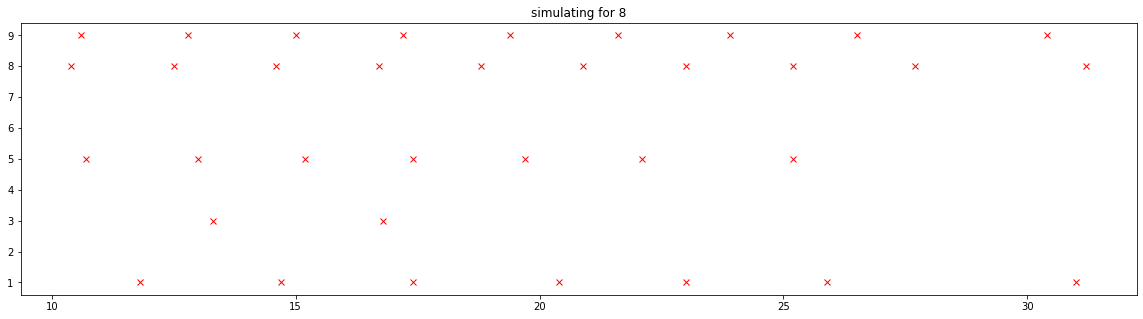

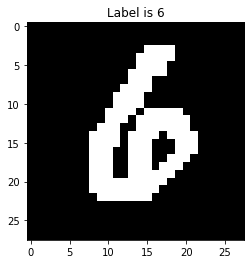

first mat dims torch.Size([784, 100])
last mat dims torch.Size([100, 10])
connecting layer 784 100
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 100 10
connected 0 nodes in the layer
starting to record
for 0 found 3 spikes of frequency 3.1000000000000005
for 1 found 0 spikes 
for 2 found 5 spikes of frequency 2.775
for 3 found 0 spikes 
for 4 found 8 spikes of frequency 2.7714285714285714
for 5 found 8 spikes of frequency 2.6
for 6 found 10 spikes of frequency 2.322222222222222
for 7 found 0 spikes 
for 8 found 2 spikes of frequency 3.3999999999999986
for 9 found 7 spikes of frequency 2.4166666666666665
ANN result: tensor([[  0., -10.,   4., -22.,   6.,   4.,  32., -12.,  -2.,   4.]],
       grad_fn=<MmBackward>)
simulation result:


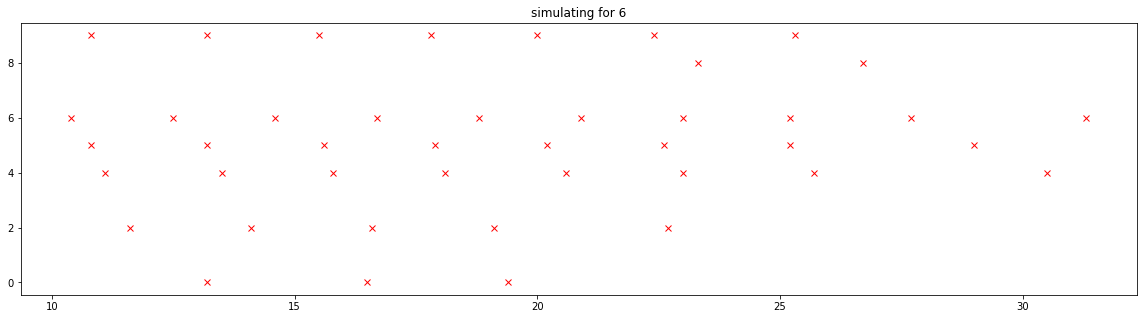

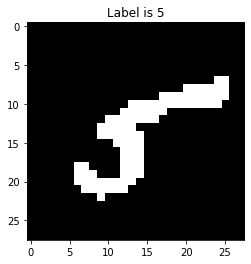

first mat dims torch.Size([784, 100])
last mat dims torch.Size([100, 10])
connecting layer 784 100
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 100 10
connected 0 nodes in the layer
starting to record
for 0 found 0 spikes 
for 1 found 7 spikes of frequency 2.5833333333333335
for 2 found 0 spikes 
for 3 found 7 spikes of frequency 2.4166666666666665
for 4 found 1 spikes 
for 5 found 9 spikes of frequency 2.2125
for 6 found 0 spikes 
for 7 found 0 spikes 
for 8 found 8 spikes of frequency 2.3428571428571425
for 9 found 0 spikes 
ANN result: tensor([[ -6.,   4.,  -2.,   4.,   0.,  34.,  -2., -22.,  20., -10.]],
       grad_fn=<MmBackward>)
simulation result:


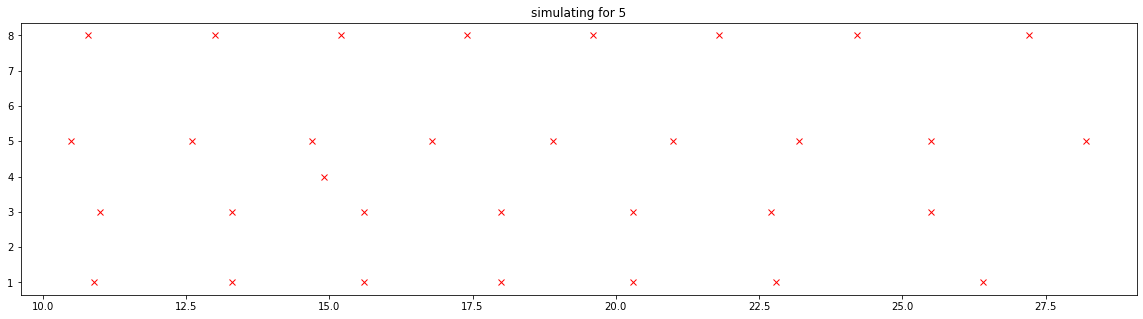

In [63]:
def Binarize(tensor, include_zero=False):
    if include_zero:
        N_std = 1
        up = (tensor > 0 + N_std * tensor.std()).float()
        down = (tensor < 0 - N_std * tensor.std()).float().mul(-1)
        return (up + down)
    else:
        return tensor.sign()


class BinarizeLinear(nn.Linear):

    def __init__(self, *kargs, **kwargs):
        super(BinarizeLinear, self).__init__(*kargs, **kwargs)

    def forward(self, input):

        if input.size(1) != 784:
            input.data = Binarize(input.data)
        if not hasattr(self.weight, 'org'):
            self.weight.org = self.weight.data.clone()
        self.weight.data = Binarize(self.weight.org)
        out = nn.functional.linear(input, self.weight)
        if not self.bias is None:
            self.bias.org = self.bias.data.clone()
            out += self.bias.view(1, -1).expand_as(out)

        return out


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = BinarizeLinear(784, 50, bias=False)
        self.bn1 = nn.BatchNorm1d(50)
        self.htanh1 = nn.Hardtanh()
        self.fc2 = BinarizeLinear(50, 10, bias=False)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = self.fc2(x)
        return x
    
model = Net()
model.load_state_dict(torch.load("mnist_trained_tiny.pt",map_location=torch.device('cpu')))
model.eval()
testMNIST(model)


# debug

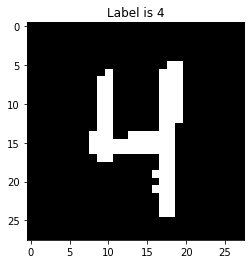

first mat dims torch.Size([784, 100])
last mat dims torch.Size([100, 10])
connecting layer 784 100
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 50 50
connected 0 nodes in the layer
connecting layer 50 50
connected 0 nodes in the layer
connecting layer 100 10
connected 0 nodes in the layer
starting to record
for 0 found 0 spikes 
for 1 found 0 spikes 
for 2 found 0 spikes 
for 3 found 0 spikes 
for 4 found 3 spikes of frequency 2.749999999999999
for 5 found 0 spikes 
for 6 found 0 spikes 
for 7 found 0 spikes 
for 8 found 0 spikes 
for 9 found 1 spikes 
ANN result: tensor([[-10.,  -7., -16.,  -6.,   4.,  -9.,  -5., -12., -10.,   2.]],
       grad_fn=<MmBackward>)
simulation result:


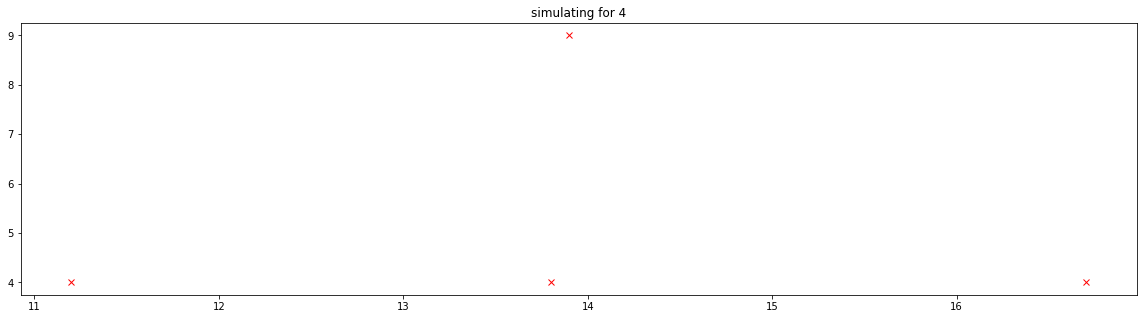

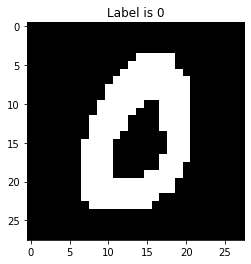

first mat dims torch.Size([784, 100])
last mat dims torch.Size([100, 10])
connecting layer 784 100
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 50 50
connected 0 nodes in the layer
connecting layer 50 50
connected 0 nodes in the layer
connecting layer 100 10
connected 0 nodes in the layer
starting to record
for 0 found 3 spikes of frequency 2.8999999999999995
for 1 found 0 spikes 
for 2 found 0 spikes 
for 3 found 0 spikes 
for 4 found 0 spikes 
for 5 found 0 spikes 
for 6 found 0 spikes 
for 7 found 0 spikes 
for 8 found 0 spikes 
for 9 found 0 spikes 
ANN result: tensor([[  6., -15.,  -6., -10., -12.,  -7., -13., -12.,  -3., -12.]],
       grad_fn=<MmBackward>)
simulation result:


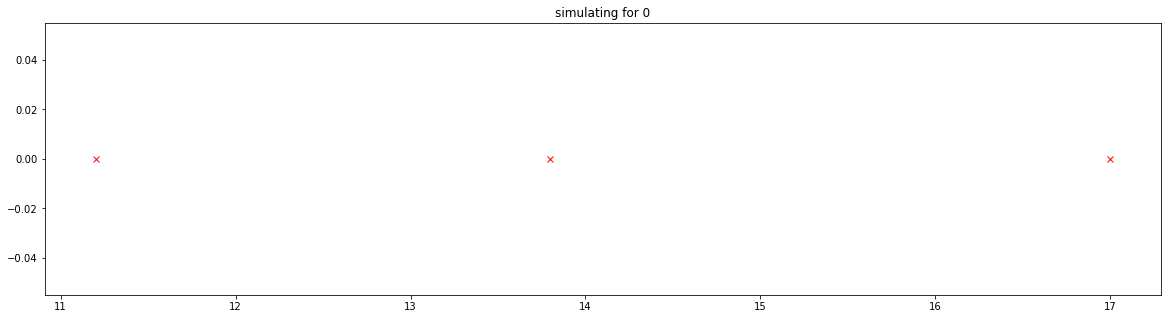

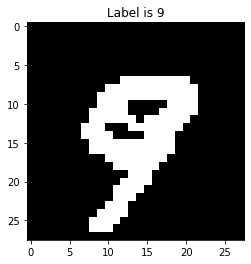

first mat dims torch.Size([784, 100])
last mat dims torch.Size([100, 10])
connecting layer 784 100
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 50 50
connected 0 nodes in the layer
connecting layer 50 50
connected 0 nodes in the layer
connecting layer 100 10
connected 0 nodes in the layer
starting to record
for 0 found 0 spikes 
for 1 found 0 spikes 
for 2 found 0 spikes 
for 3 found 0 spikes 
for 4 found 0 spikes 
for 5 found 0 spikes 
for 6 found 0 spikes 
for 7 found 0 spikes 
for 8 found 0 spikes 
for 9 found 2 spikes of frequency 3.8000000000000007
ANN result: tensor([[-10.,  -7., -20., -16.,  -8., -10.,  -5.,   0.,  -1.,   3.]],
       grad_fn=<MmBackward>)
simulation result:


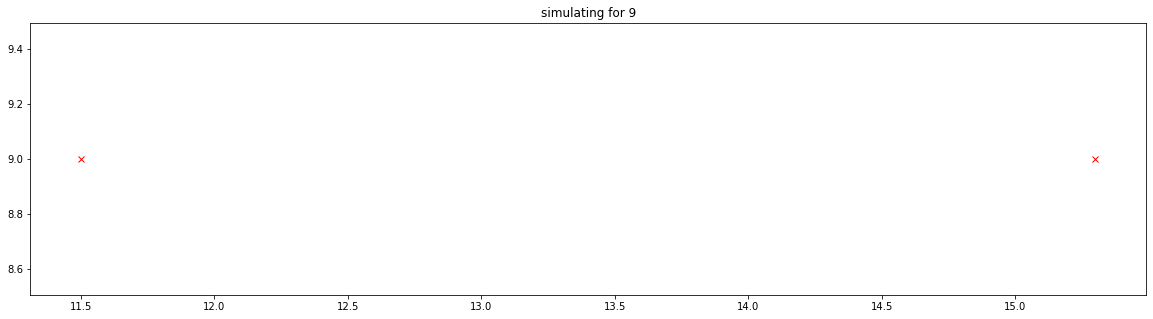

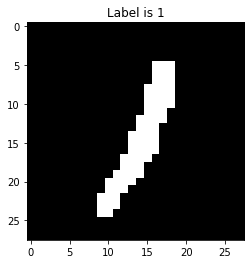

first mat dims torch.Size([784, 100])
last mat dims torch.Size([100, 10])
connecting layer 784 100
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 50 50
connected 0 nodes in the layer
connecting layer 50 50
connected 0 nodes in the layer
connecting layer 100 10
connected 0 nodes in the layer
starting to record
for 0 found 0 spikes 
for 1 found 4 spikes of frequency 3.1666666666666665
for 2 found 0 spikes 
for 3 found 0 spikes 
for 4 found 0 spikes 
for 5 found 0 spikes 
for 6 found 0 spikes 
for 7 found 0 spikes 
for 8 found 0 spikes 
for 9 found 0 spikes 
ANN result: tensor([[-22.,   9.,  -2.,  -8.,  -4.,  -4., -12.,  -3.,  -5.,  -7.]],
       grad_fn=<MmBackward>)
simulation result:


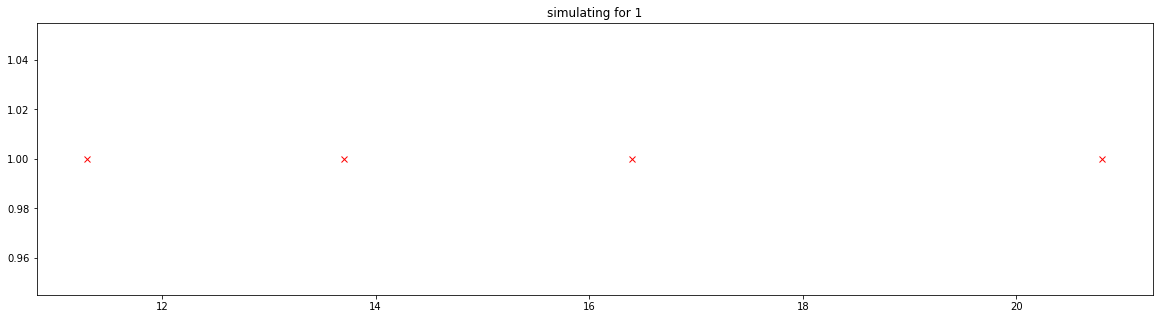

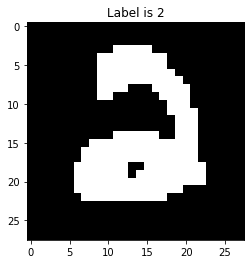

first mat dims torch.Size([784, 100])
last mat dims torch.Size([100, 10])
connecting layer 784 100
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 50 50
connected 0 nodes in the layer
connecting layer 50 50
connected 0 nodes in the layer
connecting layer 100 10
connected 0 nodes in the layer
starting to record
for 0 found 0 spikes 
for 1 found 0 spikes 
for 2 found 3 spikes of frequency 3.200000000000001
for 3 found 0 spikes 
for 4 found 0 spikes 
for 5 found 0 spikes 
for 6 found 0 spikes 
for 7 found 0 spikes 
for 8 found 0 spikes 
for 9 found 0 spikes 
ANN result: tensor([[-13., -16.,   7.,  -7., -15., -15.,  -6., -10.,  -4., -18.]],
       grad_fn=<MmBackward>)
simulation result:


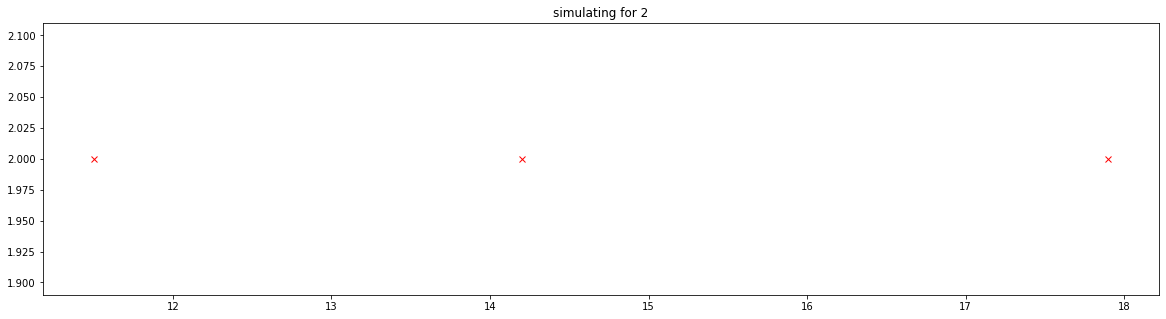

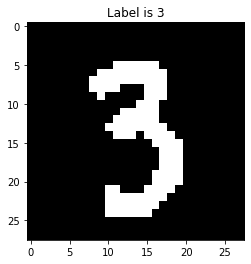

first mat dims torch.Size([784, 100])
last mat dims torch.Size([100, 10])
connecting layer 784 100
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 50 50
connected 0 nodes in the layer
connecting layer 50 50
connected 0 nodes in the layer
connecting layer 100 10
connected 0 nodes in the layer
starting to record
for 0 found 0 spikes 
for 1 found 0 spikes 
for 2 found 0 spikes 
for 3 found 4 spikes of frequency 2.5
for 4 found 0 spikes 
for 5 found 0 spikes 
for 6 found 0 spikes 
for 7 found 0 spikes 
for 8 found 0 spikes 
for 9 found 0 spikes 
ANN result: tensor([[-15., -12.,  -9.,   9., -11.,  -2., -16.,  -8., -10.,  -9.]],
       grad_fn=<MmBackward>)
simulation result:


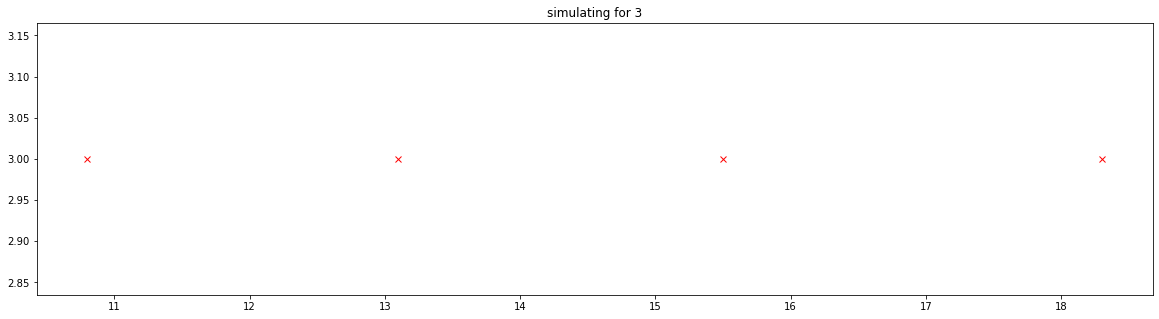

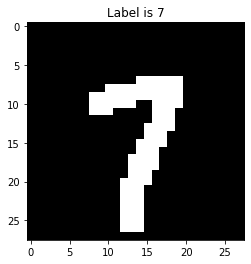

first mat dims torch.Size([784, 100])
last mat dims torch.Size([100, 10])
connecting layer 784 100
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 50 50
connected 0 nodes in the layer
connecting layer 50 50
connected 0 nodes in the layer
connecting layer 100 10
connected 0 nodes in the layer
starting to record
for 0 found 0 spikes 
for 1 found 0 spikes 
for 2 found 0 spikes 
for 3 found 0 spikes 
for 4 found 0 spikes 
for 5 found 0 spikes 
for 6 found 0 spikes 
for 7 found 4 spikes of frequency 2.8333333333333335
for 8 found 0 spikes 
for 9 found 0 spikes 
ANN result: tensor([[-13., -10.,  -7., -13.,  -9.,  -8., -12.,   8.,  -7.,   5.]],
       grad_fn=<MmBackward>)
simulation result:


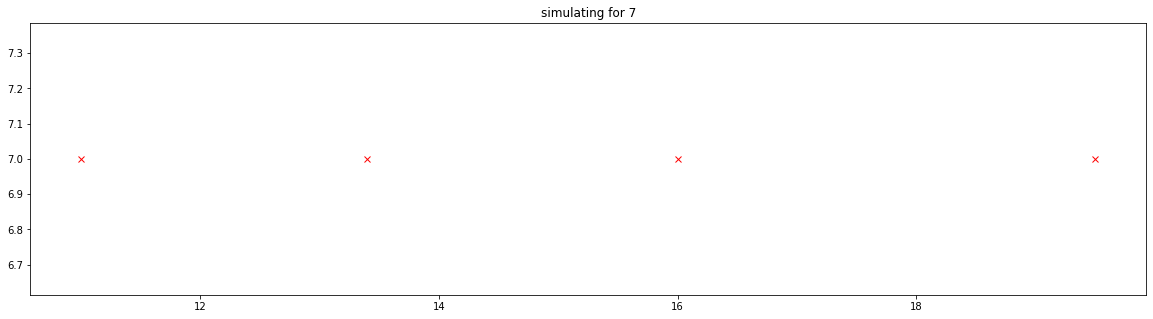

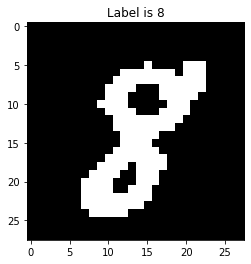

first mat dims torch.Size([784, 100])
last mat dims torch.Size([100, 10])
connecting layer 784 100
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 50 50
connected 0 nodes in the layer
connecting layer 50 50
connected 0 nodes in the layer
connecting layer 100 10
connected 0 nodes in the layer
starting to record
for 0 found 0 spikes 
for 1 found 0 spikes 
for 2 found 0 spikes 
for 3 found 0 spikes 
for 4 found 0 spikes 
for 5 found 0 spikes 
for 6 found 0 spikes 
for 7 found 0 spikes 
for 8 found 1 spikes 
for 9 found 0 spikes 
ANN result: tensor([[-10.,  -1., -14., -12., -14.,  -3., -11., -11.,   2.,  -2.]],
       grad_fn=<MmBackward>)
simulation result:


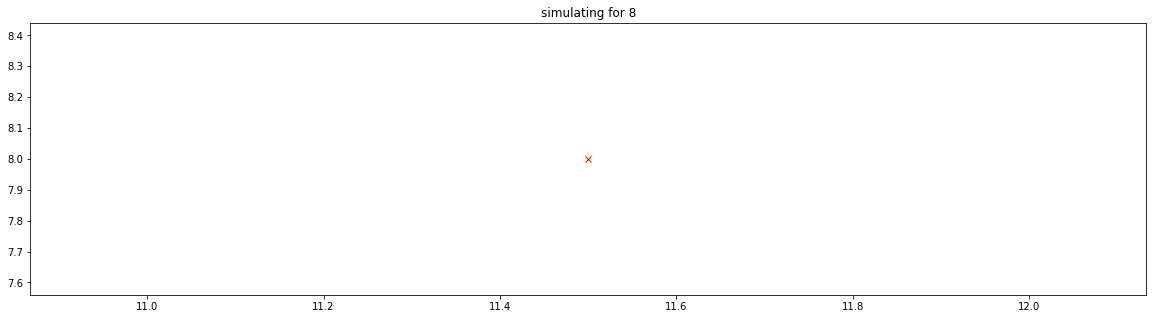

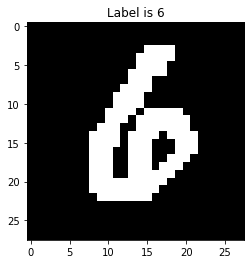

first mat dims torch.Size([784, 100])
last mat dims torch.Size([100, 10])
connecting layer 784 100
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 50 50
connected 0 nodes in the layer
connecting layer 50 50
connected 0 nodes in the layer
connecting layer 100 10
connected 0 nodes in the layer
starting to record
for 0 found 0 spikes 
for 1 found 0 spikes 
for 2 found 0 spikes 
for 3 found 0 spikes 
for 4 found 0 spikes 
for 5 found 0 spikes 
for 6 found 1 spikes 
for 7 found 0 spikes 
for 8 found 0 spikes 
for 9 found 0 spikes 
ANN result: tensor([[-11.,  -6., -10., -16., -16.,  -7.,   1.,  -7., -17., -14.]],
       grad_fn=<MmBackward>)
simulation result:


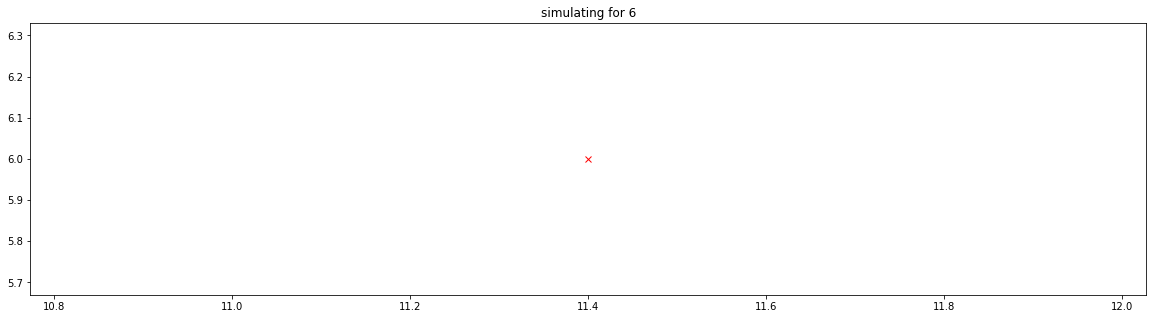

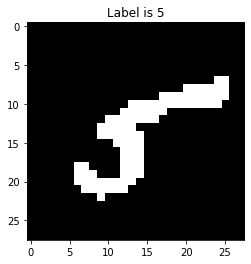

first mat dims torch.Size([784, 100])
last mat dims torch.Size([100, 10])
connecting layer 784 100
connected 0 nodes in the layer
connected 100 nodes in the layer
connected 200 nodes in the layer
connected 300 nodes in the layer
connected 400 nodes in the layer
connected 500 nodes in the layer
connected 600 nodes in the layer
connected 700 nodes in the layer
connecting layer 50 50
connected 0 nodes in the layer
connecting layer 50 50
connected 0 nodes in the layer
connecting layer 100 10
connected 0 nodes in the layer
starting to record
for 0 found 0 spikes 
for 1 found 0 spikes 
for 2 found 0 spikes 
for 3 found 0 spikes 
for 4 found 0 spikes 
for 5 found 3 spikes of frequency 3.5500000000000007
for 6 found 0 spikes 
for 7 found 0 spikes 
for 8 found 0 spikes 
for 9 found 0 spikes 
ANN result: tensor([[-12.,  -2., -14.,  -2.,  -5.,   4., -16.,  -9.,   0., -10.]],
       grad_fn=<MmBackward>)
simulation result:


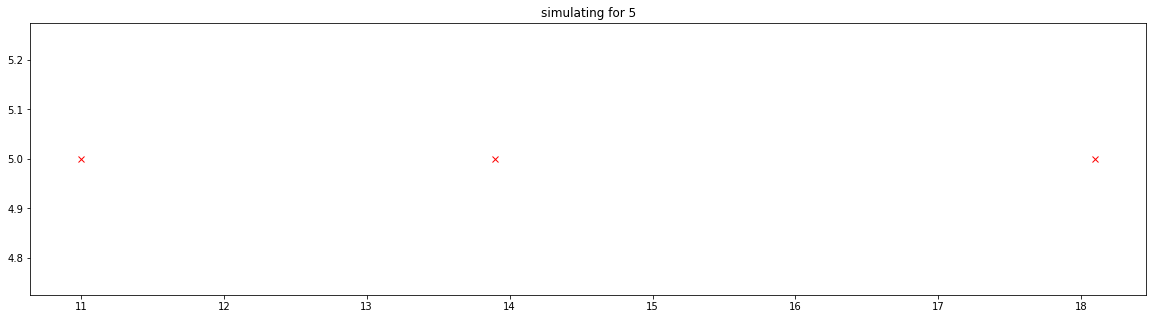

In [166]:
def Binarize(tensor, include_zero=False):
    if include_zero:
        N_std = 1
        up = (tensor > 0 + N_std * tensor.std()).float()
        down = (tensor < 0 - N_std * tensor.std()).float().mul(-1)
        return (up + down)
    else:
        return tensor.sign()


class BinarizeLinear(nn.Linear):

    def __init__(self, *kargs, **kwargs):
        super(BinarizeLinear, self).__init__(*kargs, **kwargs)

    def forward(self, input):

        if input.size(1) != 784:
            input.data = Binarize(input.data)
        if not hasattr(self.weight, 'org'):
            self.weight.org = self.weight.data.clone()
        self.weight.data = Binarize(self.weight.org)
        out = nn.functional.linear(input, self.weight)
        if not self.bias is None:
            self.bias.org = self.bias.data.clone()
            out += self.bias.view(1, -1).expand_as(out)

        return out


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = BinarizeLinear(784, 50, bias=False)
        self.fc2 = BinarizeLinear(50, 10, bias=False)
        self.activity = []

    def forward(self, x):
        x = x.view(-1, 28*28)
        self.activity.append(x)
        x = self.fc1(x)
        self.activity.append(x)
        x = self.fc2(x)
        self.activity.append(x)
        return x
    
model = Net()
model.load_state_dict(torch.load("mnist_trained_tiny_and_L1_zeroTrim2.pt",map_location=torch.device('cpu')))
model.eval()
res, model_act = testMNIST(model)

{0: {'M-a': 1,
     'N-a': 0,
     'N-t': array([], dtype=float64),
     'N-x': '0*-0.0::-0.0',
     'P-a': 1,
     'P-s': '1*0.0::0.0',
     'P-t': array([10.6]),
     'signals are not negative together': True,
     'singal match model': True},
 1: {'M-a': -1,
     'N-a': 1,
     'N-t': array([ 8.7, 10.8, 13. , 15.3, 18.1]),
     'N-x': '1*-1.0::-1.0',
     'P-a': 0,
     'P-s': '0*1.0::0.0',
     'P-t': array([], dtype=float64),
     'signals are not negative together': True,
     'singal match model': True},
 2: {'M-a': -1,
     'N-a': 1,
     'N-t': array([ 8.7, 10.8, 13. , 15.3, 18. ]),
     'N-x': '1*-0.0::-0.0',
     'P-a': 0,
     'P-s': '0*0.0::0.0',
     'P-t': array([], dtype=float64),
     'signals are not negative together': True,
     'singal match model': True},
 3: {'M-a': -1,
     'N-a': 1,
     'N-t': array([ 8.8, 11. , 13.3, 15.8, 19.5]),
     'N-x': '1*-0.0::-0.0',
     'P-a': 0,
     'P-s': '0*0.0::0.0',
     'P-t': array([], dtype=float64),
     'signals are not n

      'P-a': 1,
      'P-s': '1*1.0::1.0',
      'P-t': array([ 8.7, 10.8, 13. , 15.4, 18.3]),
      'signals are not negative together': True,
      'singal match model': True},
 44: {'M-a': 1,
      'N-a': 0,
      'N-t': array([], dtype=float64),
      'N-x': '0*-1.0::-0.0',
      'P-a': 1,
      'P-s': '1*1.0::1.0',
      'P-t': array([ 9.2, 11.6, 14.5]),
      'signals are not negative together': True,
      'singal match model': True},
 45: {'M-a': 1,
      'N-a': 0,
      'N-t': array([], dtype=float64),
      'N-x': '0*-0.0::-0.0',
      'P-a': 1,
      'P-s': '1*0.0::0.0',
      'P-t': array([ 9. , 11.3, 13.8, 17.1]),
      'signals are not negative together': True,
      'singal match model': True},
 46: {'M-a': -1,
      'N-a': 1,
      'N-t': array([10.6]),
      'N-x': '1*1.0::1.0',
      'P-a': 0,
      'P-s': '0*-1.0::-0.0',
      'P-t': array([], dtype=float64),
      'signals are not negative together': True,
      'singal match model': True},
 47: {'M-a': 1,
      'N-

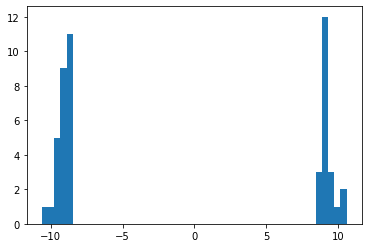

In [124]:
from pprint import pprint
def testSim(res, model_act, number,layer,targetInNextLayer):
    modelLayer = getattr(model, "fc"+str(layer+1))
    
    spikes = res[number][layer]
    weights = torch.cat((modelLayer.weight[targetInNextLayer],-1*modelLayer.weight[targetInNextLayer]),0)

    model_act = model_act[number][layer][0]
    sum = 0
    parse = {}
    hist = []
    for spike, weight, i in zip(spikes, weights, list(range(int(len(weights)/2)))*2):
        signal = 1 if list(spike) != [] else 0
        sum += signal*weight
        if i in parse.keys():
            if list(spike) != []:
                hist.append(-1*spike[0])
            parse[i].update({"N-x":f"{signal}*{weight}::{signal*weight}"})
            parse[i].update({"N-a":signal})
            parse[i].update({"N-t":spike})
            parse[i].update({"signals are not negative together":parse[i]["P-a"]+parse[i]["N-a"]==1 or (parse[i]["P-a"] and parse[i]["N-a"]==0)})
            parse[i].update({"M-a":int(model_act[i])})
            parse[i].update({"singal match model":(parse[i]["P-a"] == int(model_act[i])) or (parse[i]["N-a"] == -1*int(model_act[i]))})
        else:
            if list(spike) != []:
                hist.append(spike[0])
            parse.update({i:{"P-s":f"{signal}*{weight}::{signal*weight}",
                             "P-a":signal,
                             "P-t":spike}})
    plt.figure()
    plt.hist(hist,bins=50)
    return (parse, int(sum))

parse, sum = testSim(res, model_act,4,1,4)
pprint(parse)
print("sum:",sum)

In [51]:
pprint(len(res[4]))

3
